# Lab 3: Stochastic Gradient Descent

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD3"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L3_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

In [3]:
import pandas as pd
import plotly.express as px

# Assuming you've already loaded your data into the 'data' variable
y = data.iloc[:, -1]

# Create histogram using Plotly
fig = px.histogram(y, title='Distribution of Target Data', labels={'value': 'Target Value', 'count': 'Count'}, 
                   nbins=2, category_orders={"value": [-1, 1]})
fig.show()

We can see that the data is splitted with a lot of -1 and a few 1

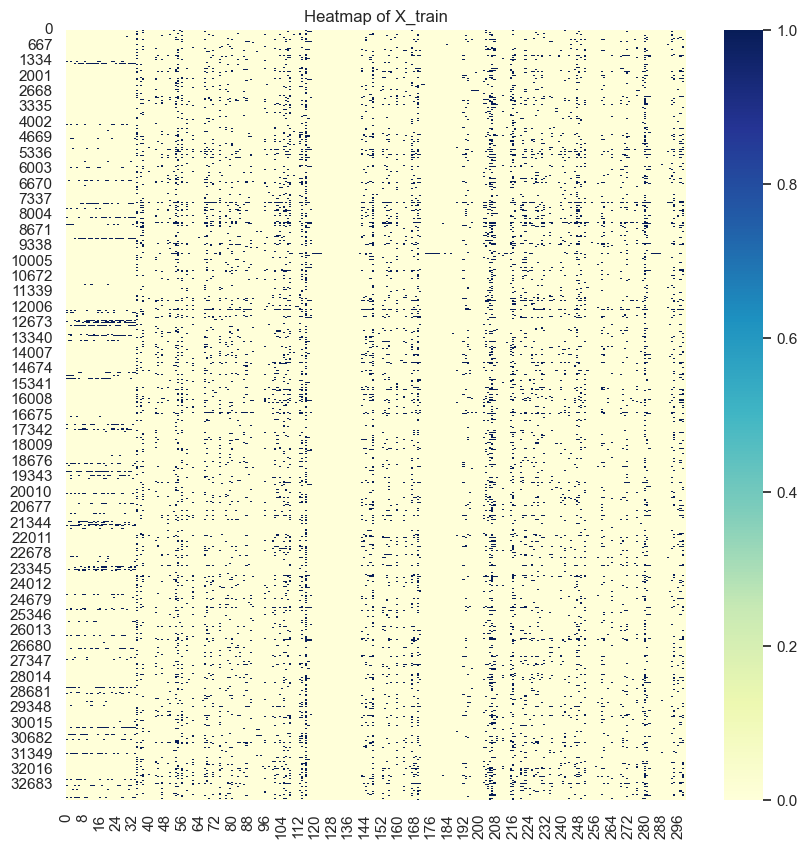

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train, cmap="YlGnBu")
plt.title('Heatmap of X_train')
plt.show()

The heatmap shows a lot of yellow regions, indicating a significant number of values zero. This suggests that the X_train dataset is sparse, meaning many features (or columns) for a lot of the data points (or rows) have values zero. The color scale on the right indicates the range of values in the dataset. The majority of the data is concentrated around the lower values (as indicated by the prevalence of the yellow color). There are some regions with darker shades of blue, indicating higher values, but these are comparatively fewer.

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
model = LogisticRegression(random_state=0, solver='saga')

# Define the hyperparameters and their possible values
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Set up grid search
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1) 

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters: {'C': 100, 'penalty': 'l1'}


and we compute the accuracy score to evaluate the model performance:

The accuracy score is: 0.985
The precision score is: 0.885
The recall score is: 0.605
The F1 score is: 0.719
The ROC AUC score is: 0.801


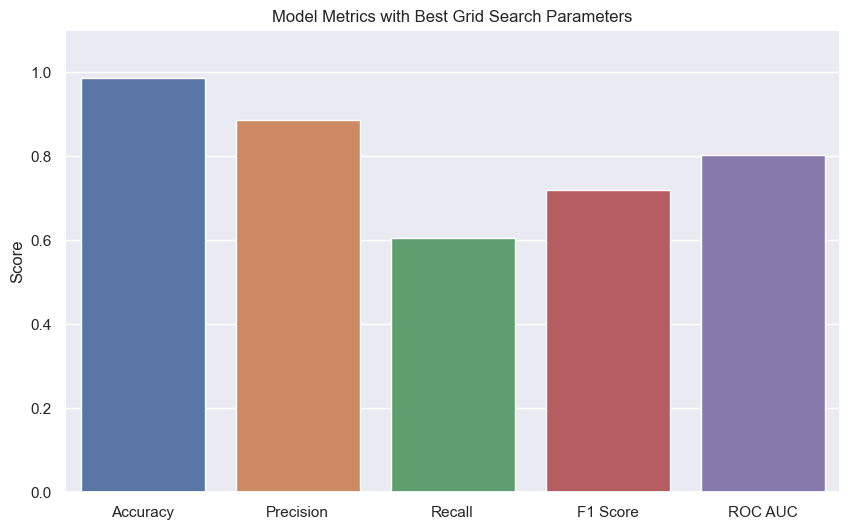

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print(f"The accuracy score is: {accuracy:.3f}")
print(f"The precision score is: {precision:.3f}")
print(f"The recall score is: {recall:.3f}")
print(f"The F1 score is: {f1:.3f}")
print(f"The ROC AUC score is: {roc_auc:.3f}")

# Create a visualization for the metrics
metrics_data = [accuracy, precision, recall, f1, roc_auc]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_labels, y=metrics_data)
plt.title('Model Metrics with Best Grid Search Parameters')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.show()

This is our baseline for the following part of the practicle.

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [7]:
class StochasticLogisticRegression():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                                              Default value
    coef_         : 1-dimensional np.array, coefficients / weights                         | None                
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """
    def __init__(self, lambd=2, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False, thresh=0.5):
        self.coef_ = None
        self.lambd_ = lambd
        self.lr_ = lr
        self.bsize_ = batchsize
        self.gamma_ = gamma
        self.beta_ = beta
        self.eps_ = eps
        self.debias_ = debias
        self.coef_history_ = []
        self.f_history_ = []
        self.thresh_ = thresh
        
    # UTILITIES FUNCTIONS
    def logistic(self, z):
        return 1 / (1 + np.exp(-z))
    
    def get_params(self, i, g_t, m_t, s_t, method="ADAM"):
        if method == "ADAM":
            m_t = self.beta_*m_t+(1-self.beta_)*g_t
            s_t = self.gamma_*s_t+(1-self.gamma_)*g_t**2
            if self.debias_:
                m_t = m_t / (1-self.beta_**(i+1))
                s_t = s_t / (1-self.gamma_**(i+1))
            return m_t, s_t
                
        elif method == "RMSprop":
            m_t = g_t
            s_t = self.gamma_*s_t+(1-self.gamma_)*g_t**2
            return m_t, s_t
        
        elif method == "Adagrad":
            m_t = g_t
            s_t = s_t + g_t**2
            return m_t, s_t
            
        elif method == "Vanilla":
            m_t = g_t
            s_t = 1
            return m_t, s_t
        
        else: 
            print("Warning ! Wrong method name. ADAM used.")
            m_t = self.beta_*m_t+(1-self.beta_)*g_t
            s_t = self.gamma_*s_t+(1-self.gamma_)*g_t**2
            if self.debias_:
                m_t = m_t / (1-self.beta_**(i+1))
                s_t = s_t / (1-self.gamma_**(i+1)) 
            return m_t, s_t
                
    # PRINCIPAL FUNCTION
    def fit(self, X, y, lr=1e-2, bsize=64, max_iter=100, minibatch=False, method="ADAM", penalty="l2"):
        
        """ Fit the data (X, y).
    
        Parameters:
        -----------                                                                         Default value
        X          : (num_samples, num_features) np.array, Design matrix                  | 
        y          : (num_sampes, ) np.array,              Output vector                  | 
        lr         : float,                                the learning rate              | 0.001
        bsize      : integer,                              the size of the mini-batch >=1 | 64
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 use of bacth                   | False
        method     : string,                               method                         | "ADAM"
        """
        def f(w, penalty):
            if penalty=="l2":
                return np.sum(np.log(1 + np.exp(-y*np.dot(X, w.T)))) + lambd*np.linalg.norm(w)**2/2
            elif penalty=="l1":
                return np.sum(np.log(1 + np.exp(-y*np.dot(X, w.T)))) + lambd*np.linalg.norm(w)
            elif penalty=="elasticnet":
                return np.sum(np.log(1 + np.exp(-y*np.dot(X, w.T)))) + lambd*np.linalg.norm(w)**2/2 + lambd*np.linalg.norm(w)
            else:
                print("Warning ! Wrong penalty name. l2 used.")
                return np.sum(np.log(1 + np.exp(-y*np.dot(X, w.T)))) + lambd*np.linalg.norm(w)**2/2
                
                
       
        def grad_f(w, batch):
            g_t = -np.sum(y[batch]*(1-self.logistic(y[batch]*np.dot(X[batch],(w.T))))*X[batch],axis=0).reshape((1,p))
            g_t+= lambd*w
            return g_t
        
        self.bsize_ = bsize
        self.lr_    = lr
        lambd       = self.lambd_
        n, p        = X.shape
        y           = y.reshape(n,1)
        self.coef_  = np.random.random((1,p))
        
        batch_number = int(n/self.bsize_)
        m_t = 0
        s_t = 0
        
        for i in tqdm(range(max_iter)):
            
            if minibatch:                     
                l = np.array(range(n))
                np.random.shuffle(l)
                batches = np.split(l[:-(n%batch_number)], batch_number)
                
                for batch in batches:
                    g_t = grad_f(self.coef_, batch)
                    m_t, s_t = self.get_params(i, g_t, m_t, s_t, method) 
                    self.coef_ = self.coef_ - lr*m_t/np.sqrt(s_t+self.eps_)
                
            else:  
                g_t = grad_f(self.coef_,np.array(range(n)))
                m_t, s_t = self.get_params(i, g_t, m_t, s_t, method) 
                self.coef_ = self.coef_ - lr*m_t/np.sqrt(s_t+self.eps_)
                
            loss = f(self.coef_, penalty)
            self.coef_history_.append(self.coef_)
            self.f_history_.append(loss)

        # get best coefs ie coefs that minimize the loss
        self.coef_ = self.coef_history_[np.argmin(self.f_history_)]

    
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions (0 or 1)
        """
        return self.logistic(np.dot(X,self.coef_[0].T))

    def accuracy_evaluation(self, X, y, thresh=0.5, margin=0, vizualisation=True):
        """ Compute detailed accuracy rates.
    
        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    | 
        y                : (num_samples, ) np.array, Labels of the input data  | 
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True
            
        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels 
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """  
        y_pred = self.predict(X)
        diff = y_pred - (thresh + margin)  # Difference between y_pred and upper threshold
        metrics = {}

        # Initialize metrics
        metrics["TP"] = np.sum((y == 1) & (diff > 0))
        metrics["UP"] = np.sum((y == 1) & (np.abs(diff) <= 0))
        metrics['FN'] = np.sum((y == 1) & (diff < 0))
        metrics['TN'] = np.sum((y == -1) & (diff < 0))
        metrics['FP'] = np.sum((y == -1) & (diff > 0))
        metrics['UN'] = np.sum((y == -1) & (np.abs(diff) <= 0))

        metrics["P"] = metrics["TP"] + metrics["UP"] + metrics["FN"]
        metrics["N"] = metrics["TN"] + metrics["UN"] + metrics["FP"]

        metrics['TP'] = metrics['TP'] / (metrics['P'] + 1e-10)
        metrics['UP'] = metrics['UP'] / (metrics['P'] + 1e-10)
        metrics['FN'] = metrics['FN'] / (metrics['P'] + 1e-10)
        metrics['TN'] = metrics['TN'] / (metrics['N'] + 1e-10)
        metrics['UN'] = metrics['UN'] / (metrics['N'] + 1e-10)
        metrics['FP'] = metrics['FP'] / (metrics['N'] + 1e-10)

        metrics['good_pred'] = (metrics['TP'] * metrics['P'] + metrics['TN'] * metrics['N']) / len(X)
        metrics['undetermined'] = (metrics['UP'] * metrics['P'] + metrics['UN'] * metrics['N']) / len(X)
        metrics['wrong_pred'] = (metrics['FP'] * metrics['N'] + metrics['FN'] * metrics['P']) / len(X)
        metrics['F1_score'] = metrics['TP'] / (metrics['TP'] + 0.5 * (metrics['FP'] + metrics['FN']))

        if vizualisation:
            print(f"good_pred: {metrics['good_pred']}") 
            print(f"undetermined: {metrics['undetermined']}")
            print(f"wrong_pred: {metrics['wrong_pred']}\n")
            print(f"TP: {metrics['TP']}")
            print(f"UP: {metrics['UP']}")
            print(f"FN: {metrics['FN']}")
            print(f"TN: {metrics['TN']}")
            print(f"UN: {metrics['UN']}")
            print(f"FP: {metrics['FP']}")
            print(f"P: {metrics['P']}")
            print(f"N: {metrics['N']}")
            print('f1_score: ', metrics['F1_score']) 

        return metrics


    def find_thresh(self, X, y, step=0.01, margin=0):
        """Find the decision threshsold that maximize the f1_score
        
        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    | 
        y      : (num_samples, ) np.array, Labels of the input data  | 
        step   : Decision threshold                                  | 0.5
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """  
        nb_steps = int(1/step)
        thresholds = np.linspace(0, 1, num=nb_steps, endpoint=False)
        f_scores = []
        
        for thresh in tqdm(thresholds):
            metrics_i = self.accuracy_evaluation(X, y, thresh, margin, vizualisation=False)
            f_scores.append(metrics_i["F1_score"])
        
        f_scores = np.array(f_scores)
        best_thresh = step * np.argmax(f_scores)
        
        # Beautiful plot enhancements
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, f_scores, color='royalblue', linewidth=2)
        plt.axvline(x=best_thresh, color='red', linestyle='--', linewidth=2)
        plt.title("F1-score throughout different thresholds", fontsize=16)
        plt.xlabel("Threshold", fontsize=14)
        plt.ylabel("F1-score", fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        
        # Annotations
        plt.annotate(f'Max F1-Score: {f_scores.max():.3f}', 
                     xy=(best_thresh, f_scores.max()), 
                     xytext=(best_thresh-0.2, f_scores.max()-0.1),
                     arrowprops=dict(arrowstyle='->', color='black'), 
                     fontsize=12)
        
        plt.annotate(f'Best Threshold: {best_thresh:.3f}', 
                     xy=(best_thresh, f_scores.max()-0.05), 
                     xytext=(best_thresh-0.05, f_scores.max()-0.15),
                     arrowprops=dict(arrowstyle='->', color='black'), 
                     fontsize=12)
        
        plt.show()


Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 2**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

## Training of the model and Optimal threshold

# ADAM Method

In [8]:
%time
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="ADAM")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


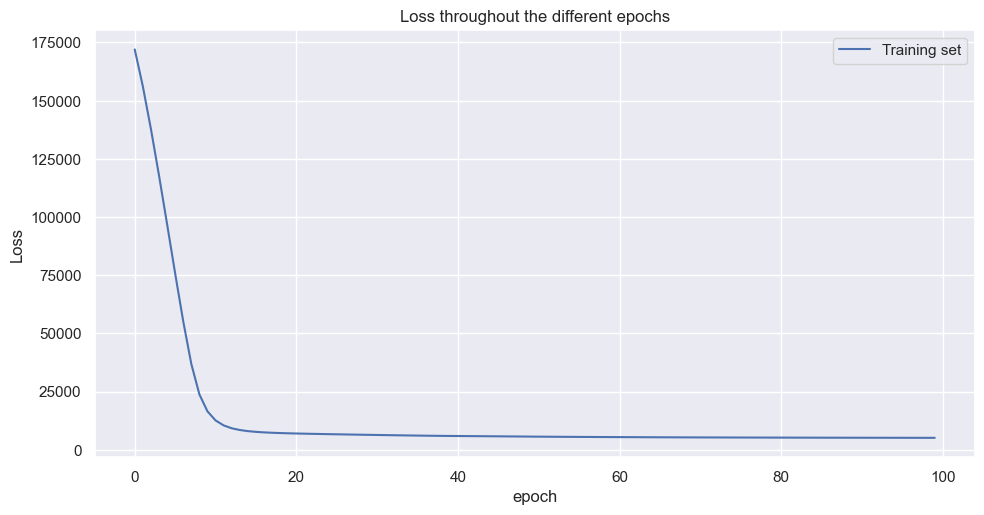

100%|██████████| 100/100 [00:00<00:00, 114.01it/s]


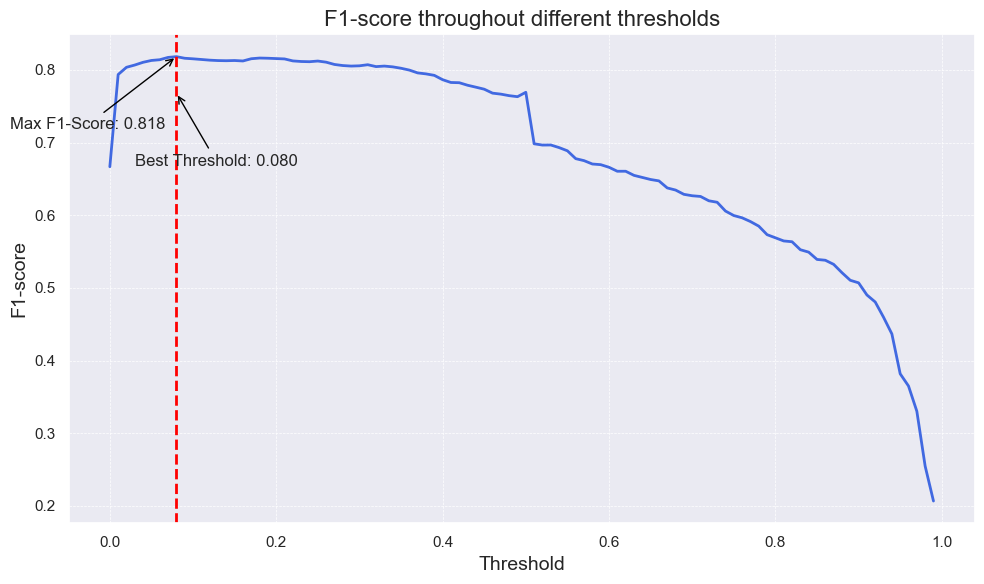

good_pred: 0.9026731871230944
undetermined: 0.08349584470912909
wrong_pred: 0.013830968167770732

TP: 0.5608465608465014
UP: 0.10687830687829557
FN: 0.3322751322750971
TN: 0.912647440251958
UN: 0.08281356141542617
FP: 0.004538998332612843
P: 945
N: 32386
f1_score:  0.7690692795141028
good_pred: 0.8987696430746651
undetermined: 0.08649043732488612
wrong_pred: 0.01473991960043652

TP: 0.5636704119849131
UP: 0.10861423220971748
FN: 0.3277153558051821
TN: 0.9100352556031169
UN: 0.08574666330898964
FP: 0.004218081087887155
P: 534
N: 15884
f1_score:  0.7725352623592558


{'TP': 0.5636704119849131,
 'UP': 0.10861423220971748,
 'FN': 0.3277153558051821,
 'TN': 0.9100352556031169,
 'FP': 0.004218081087887155,
 'UN': 0.08574666330898964,
 'P': 534,
 'N': 15884,
 'good_pred': 0.8987696430746651,
 'undetermined': 0.08649043732488612,
 'wrong_pred': 0.01473991960043652,
 'F1_score': 0.7725352623592558}

In [9]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_)

The Adam method seems to present good results, but it is less efficienccy on the TP than TN, let's compare it with other methods and challenge these results

# RMSprop

In [10]:
%time
#UPGRADE PLOTS
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="RMSprop")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


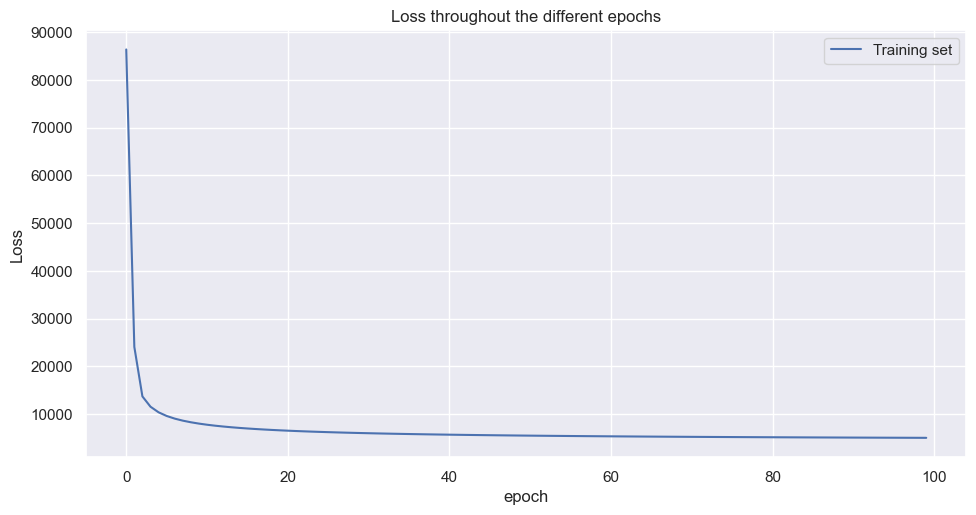

100%|██████████| 100/100 [00:00<00:00, 120.28it/s]


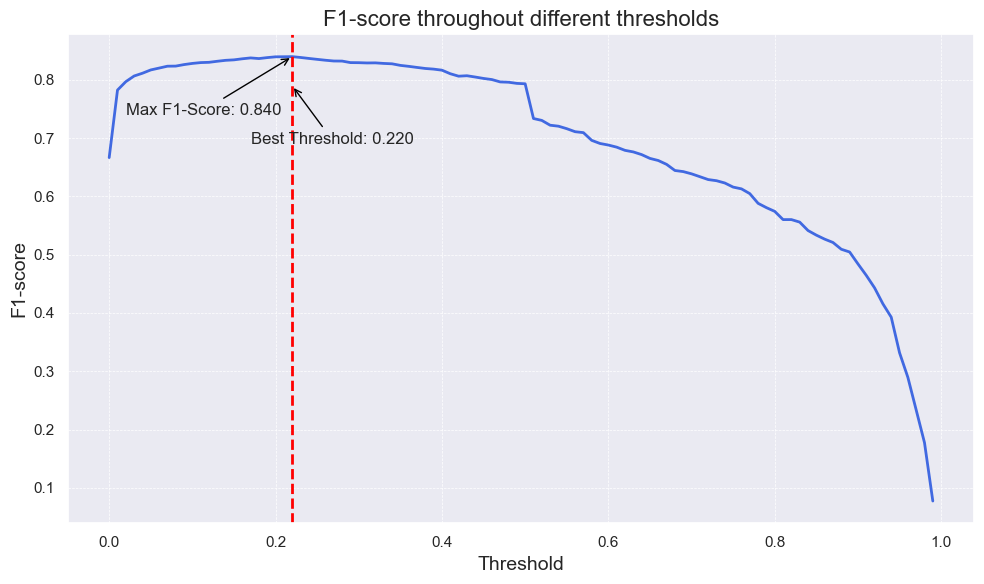

good_pred: 0.9030932165251523
undetermined: 0.08349584470912909
wrong_pred: 0.01341093876571268

TP: 0.590476190476128
UP: 0.10687830687829557
FN: 0.30264550264547063
TN: 0.912215154696471
UN: 0.08281356141542617
FP: 0.004971283888099781
P: 945
N: 32386
f1_score:  0.7933473343041687
good_pred: 0.898769643074665
undetermined: 0.08649043732488612
wrong_pred: 0.01473991960043662

TP: 0.5805243445691797
UP: 0.10861423220971748
FN: 0.31086142322091553
TN: 0.9094686476957888
UN: 0.08574666330898964
FP: 0.0047846889952152805
P: 534
N: 15884
f1_score:  0.7862482403766804


{'TP': 0.5805243445691797,
 'UP': 0.10861423220971748,
 'FN': 0.31086142322091553,
 'TN': 0.9094686476957888,
 'FP': 0.0047846889952152805,
 'UN': 0.08574666330898964,
 'P': 534,
 'N': 15884,
 'good_pred': 0.898769643074665,
 'undetermined': 0.08649043732488612,
 'wrong_pred': 0.01473991960043662,
 'F1_score': 0.7862482403766804}

In [11]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_)

We can see a smaller efficiency on predictions

# Adagrad

In [12]:
%time
#UPGRADE PLOTS
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="Adagrad")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


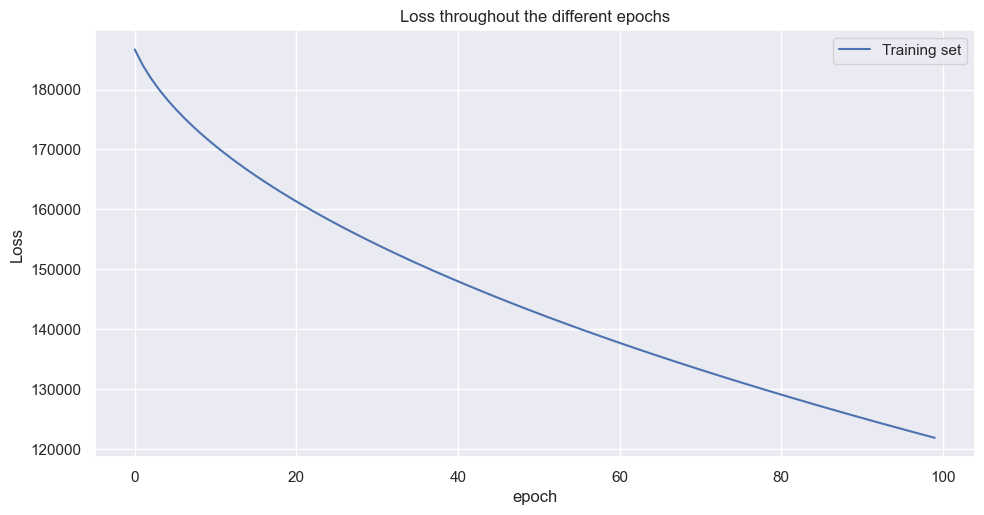

100%|██████████| 100/100 [00:00<00:00, 113.88it/s]


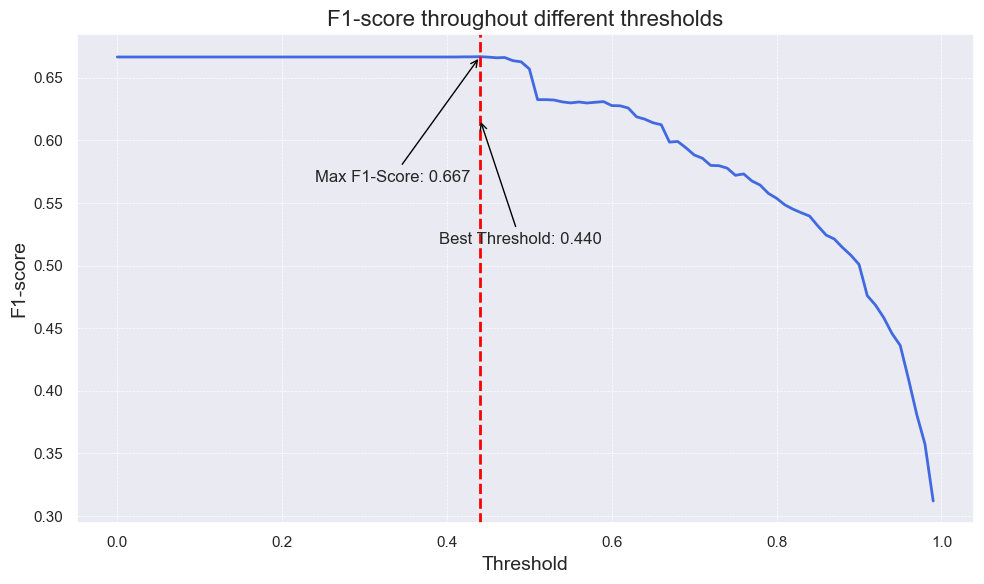

good_pred: 0.03771263988478926
undetermined: 0.08349584470912909
wrong_pred: 0.8787915154060758

TP: 0.8793650793649863
UP: 0.10687830687829557
FN: 0.0137566137566123
TN: 0.013153831902673954
UN: 0.08281356141542617
FP: 0.9040326066818969
P: 945
N: 32386
f1_score:  0.6570959928100203
good_pred: 0.041905225971489365
undetermined: 0.08649043732488612
wrong_pred: 0.8716043367036124

TP: 0.8614232209736213
UP: 0.10861423220971748
FN: 0.029962546816473788
TN: 0.014354066985645843
UN: 0.08574666330898964
FP: 0.8998992697053583
P: 534
N: 15884
f1_score:  0.6494669877273003


{'TP': 0.8614232209736213,
 'UP': 0.10861423220971748,
 'FN': 0.029962546816473788,
 'TN': 0.014354066985645843,
 'FP': 0.8998992697053583,
 'UN': 0.08574666330898964,
 'P': 534,
 'N': 15884,
 'good_pred': 0.041905225971489365,
 'undetermined': 0.08649043732488612,
 'wrong_pred': 0.8716043367036124,
 'F1_score': 0.6494669877273003}

In [13]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_)

# Vanilla

In [14]:
%%time
#UPGRADE PLOTS
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="Vanilla")

  1%|          | 1/100 [00:00<00:23,  4.22it/s]

100%|██████████| 100/100 [00:21<00:00,  4.73it/s]

CPU times: total: 55 s
Wall time: 21.1 s


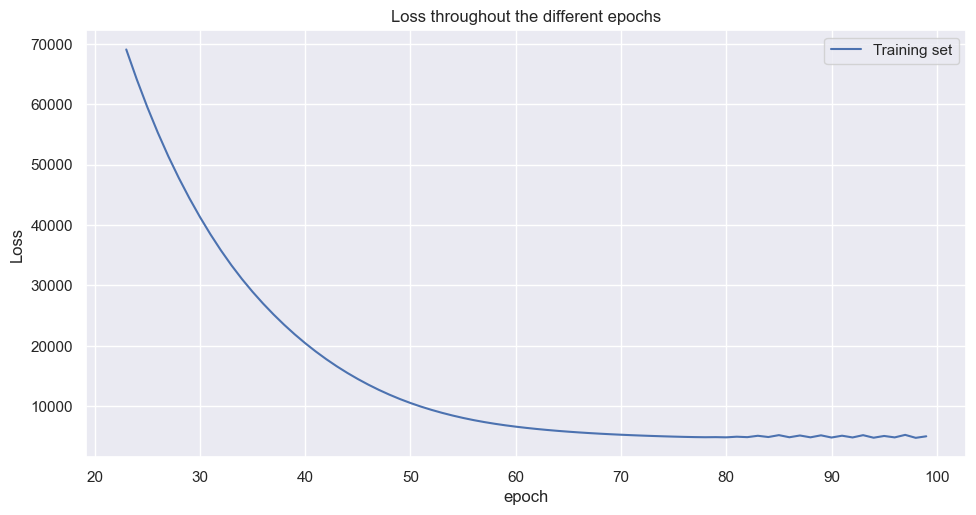

100%|██████████| 100/100 [00:00<00:00, 113.96it/s]


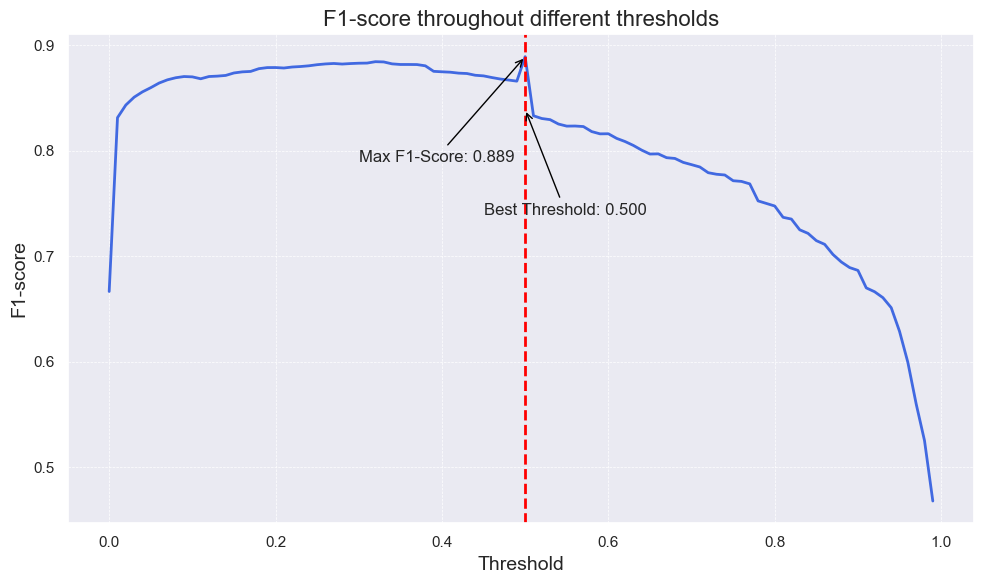

good_pred: 0.9006930485133912
undetermined: 0.08349584470912909
wrong_pred: 0.015811106777473886

TP: 0.7238095238094472
UP: 0.10687830687829557
FN: 0.1693121693121514
TN: 0.9058543815228776
UN: 0.08281356141542617
FP: 0.01133205706169329
P: 945
N: 32386
f1_score:  0.8890571142522432
good_pred: 0.8957851138993689
undetermined: 0.08649043732488612
wrong_pred: 0.017724448775732878

TP: 0.728464419475519
UP: 0.10861423220971748
FN: 0.16292134831457622
TN: 0.9014102241248999
UN: 0.08574666330898964
FP: 0.012843112566104174
P: 534
N: 15884
f1_score:  0.8923469209441869


{'TP': 0.728464419475519,
 'UP': 0.10861423220971748,
 'FN': 0.16292134831457622,
 'TN': 0.9014102241248999,
 'FP': 0.012843112566104174,
 'UN': 0.08574666330898964,
 'P': 534,
 'N': 15884,
 'good_pred': 0.8957851138993689,
 'undetermined': 0.08649043732488612,
 'wrong_pred': 0.017724448775732878,
 'F1_score': 0.8923469209441869}

In [15]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_)

Let's dive into the results of this specific methods. We have to analyse these results knowing that our dataset is quite unbalanced: actually 97% of our set is composed of label -1 and a few 1. This imply that getting a good accuracy is not a hard task for a naive algorithm

In the case of the Vanilla Method, rather it's the train or test set, the accuracy is still the same, the accuracy is not amazing ~90% ut this imply that we are avoiding overfitting

The efficiency rather it's TP or TN is quite good. To deal with the probleme of our unfair data set, we could split it in smaller and more balance sets, or penalize the algorithme in his learning phase when he failed to predict 1.

# Study of the batchsize impact

In [16]:
# --------------------------
# 1. Training the models and storing their loss histories
# --------------------------
import matplotlib.pyplot as plt

# Specify optimization methods you want to compare
methods = ["ADAM", "RMSprop", "Adagrad", "Vanilla"]

# Create dictionaries to store loss histories, accuracy histories, and models for each method and batch size
loss_histories = {method: {} for method in methods}
trained_models = {method: {} for method in methods}
accuracy_histories_train = {method: {} for method in methods}
accuracy_histories_test = {method: {} for method in methods}

batch_sizes = [None, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]  # None will be used to represent the entire dataset

for method in methods:
    print(f"Optimization method: {method}")
    for batch_size in batch_sizes:
        minibatch = batch_size is not None
        if batch_size == None :
            minibatch = False
        print(f"Using {'entire dataset' if not minibatch else 'Batch size: ' + str(batch_size)} for {method}")
        
        slr = StochasticLogisticRegression()
        # Explicitly set the bsize_ attribute
        if batch_size is None:
            slr.bsize_ = len(X_train)
        else:
            slr.bsize_ = batch_size
            
        slr.coef_ = None  # Reset coefficients for each batch size
        
        # Use the bsize_ attribute instead of batch_size in the fit method
        slr.fit(X_train, y_train, lr=slr.lr_, bsize=slr.bsize_, max_iter=100, minibatch=minibatch, method=method, penalty="l2")
        # Store the loss histories and trained models
        key = "Full Batch" if batch_size is None else batch_size
        loss_histories[method][key] = slr.f_history_
        trained_models[method][key] = slr
        
        # Calculate and store accuracy metrics for train set
        metrics_train = slr.accuracy_evaluation(X_train, y_train, thresh=slr.thresh_, vizualisation=False)
        accuracy_histories_train[method][key] = metrics_train
        
        # Calculate and store accuracy metrics for test set
        metrics_test = slr.accuracy_evaluation(X_test, y_test, thresh=slr.thresh_, vizualisation=False)
        accuracy_histories_test[method][key] = metrics_test


Optimization method: ADAM
Using entire dataset for ADAM


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


Using Batch size: 128 for ADAM


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Using Batch size: 256 for ADAM


100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


Using Batch size: 512 for ADAM


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Using Batch size: 1024 for ADAM


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Using Batch size: 2048 for ADAM


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Using Batch size: 4096 for ADAM


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Using Batch size: 8192 for ADAM


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Using Batch size: 16384 for ADAM


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Optimization method: RMSprop
Using entire dataset for RMSprop


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Using Batch size: 128 for RMSprop


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Using Batch size: 256 for RMSprop


100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


Using Batch size: 512 for RMSprop


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Using Batch size: 1024 for RMSprop


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Using Batch size: 2048 for RMSprop


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Using Batch size: 4096 for RMSprop


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Using Batch size: 8192 for RMSprop


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Using Batch size: 16384 for RMSprop


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Optimization method: Adagrad
Using entire dataset for Adagrad


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


Using Batch size: 128 for Adagrad


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Using Batch size: 256 for Adagrad


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


Using Batch size: 512 for Adagrad


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Using Batch size: 1024 for Adagrad


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


Using Batch size: 2048 for Adagrad


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Using Batch size: 4096 for Adagrad


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Using Batch size: 8192 for Adagrad


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Using Batch size: 16384 for Adagrad


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Optimization method: Vanilla
Using entire dataset for Vanilla


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


Using Batch size: 128 for Vanilla


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Using Batch size: 256 for Vanilla


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Using Batch size: 512 for Vanilla


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Using Batch size: 1024 for Vanilla


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Using Batch size: 2048 for Vanilla


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Using Batch size: 4096 for Vanilla


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Using Batch size: 8192 for Vanilla


100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Using Batch size: 16384 for Vanilla


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


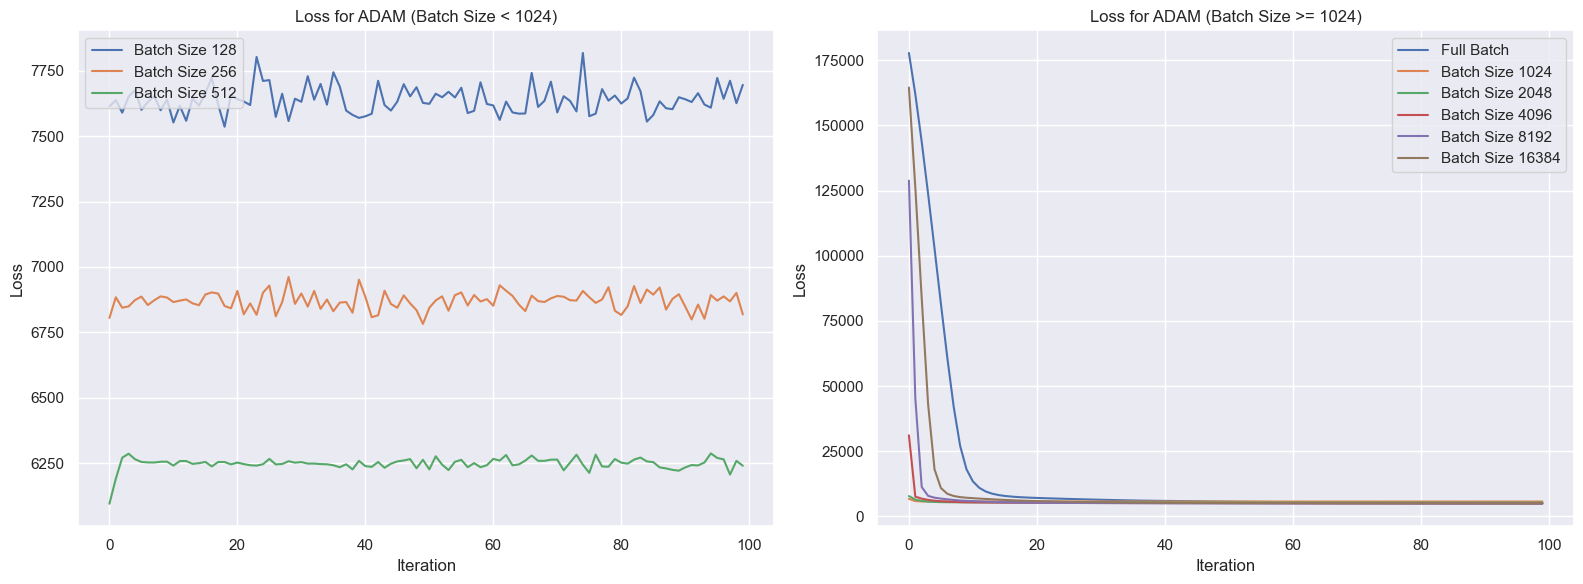

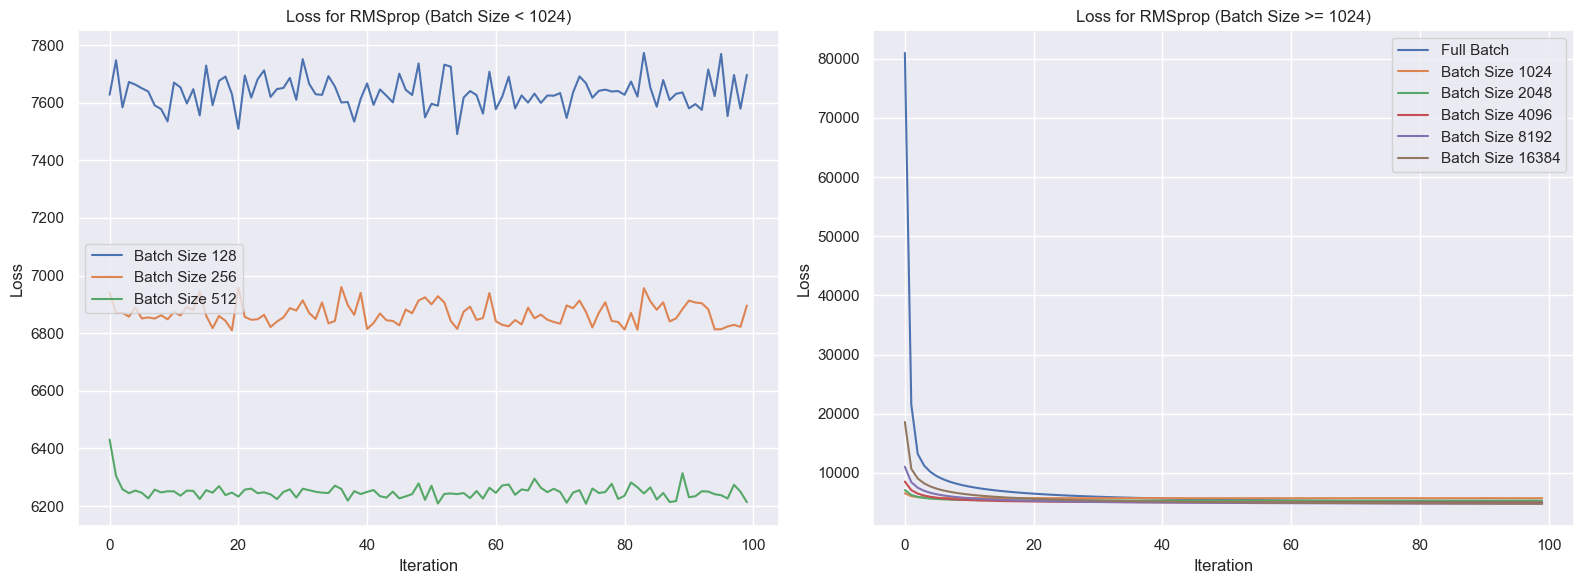

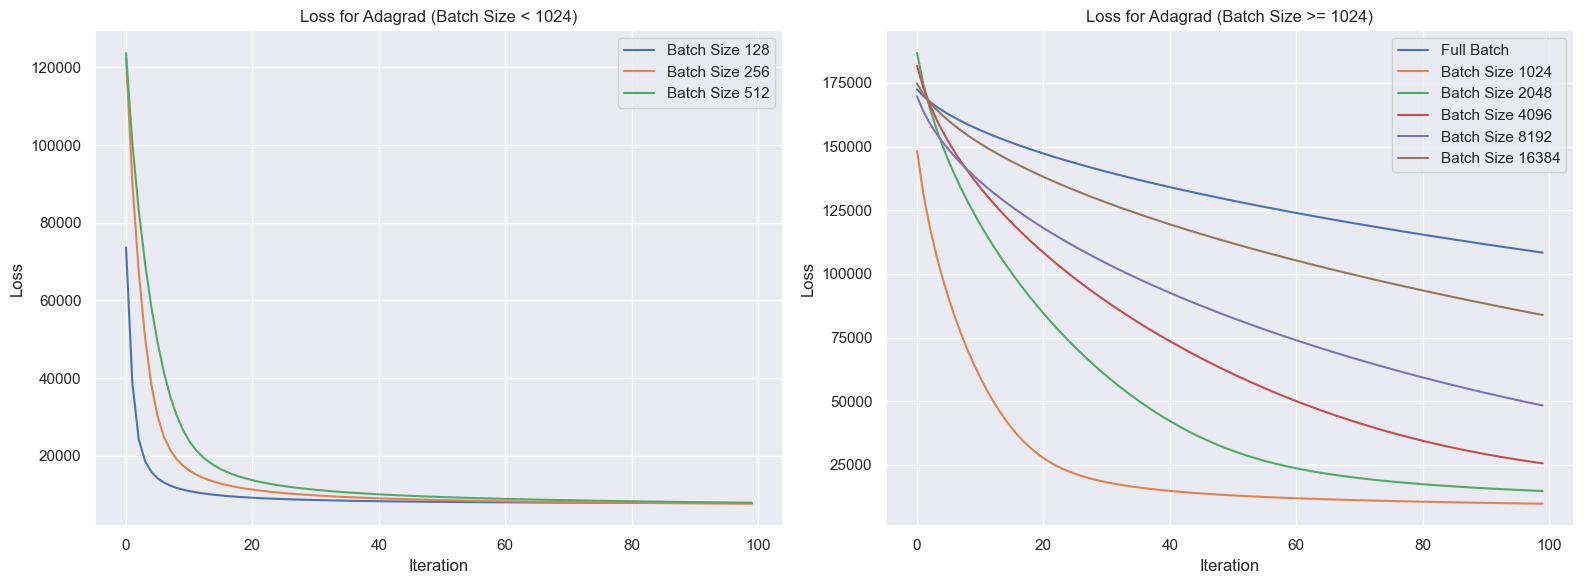

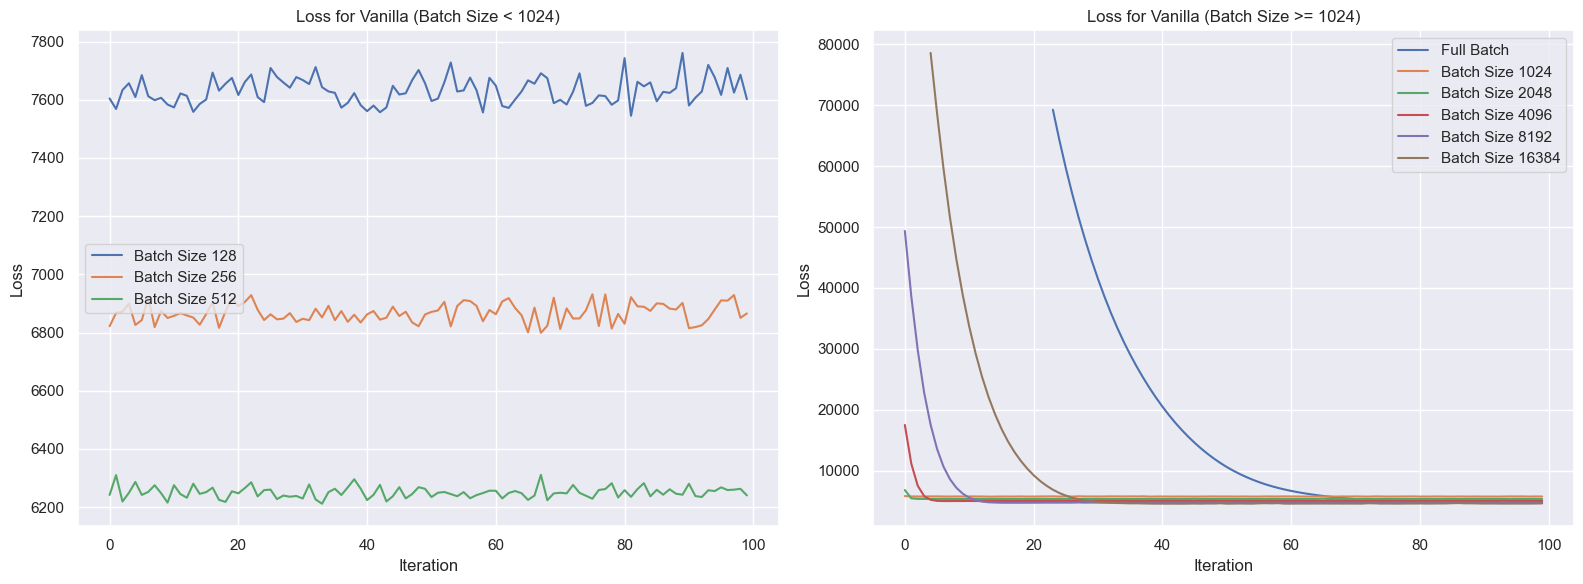

In [17]:
import matplotlib.pyplot as plt

# Define batch size categories
batch_sizes_under_1024 = [batch for batch in batch_sizes if batch is not None and batch < 1024]
batch_sizes_1024_and_above = [batch for batch in batch_sizes if batch is None or batch >= 1024]

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot for batch sizes under 1024
    axes[0].set_title(f"Loss for {method} (Batch Size < 1024)")
    for batch_size, loss_values in loss_histories[method].items():
        if batch_size in batch_sizes_under_1024:
            axes[0].plot(loss_values, label=f"Batch Size {batch_size}")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot for 'Full Batch' and batch sizes 1024 and above
    axes[1].set_title(f"Loss for {method} (Batch Size >= 1024)")
    for batch_size, loss_values in loss_histories[method].items():
        if batch_size == 'Full Batch':
            axes[1].plot(loss_values, label="Full Batch")
        elif batch_size in batch_sizes_1024_and_above:
            axes[1].plot(loss_values, label=f"Batch Size {batch_size}")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Vanilla: we can see that more the batch size is small more the loss converge fast. however under 1024 rows the loss is just a noise and the algorithm do not learn. 

Adagrada: there is no noise in the smalls batchs more the batch is small more the loss converge fast

RMSprop : same as the vanilla however the convergence difference between large batchs and smalls one is less important in the RMSprop

Adam : same as the vanilla but the convergences for large batchs are smaller that in vanilla but bigger that in RMSprop

As a conclusion, more the batchs are big more the convergence is close to the no-minibatch method. Futhermore, more the batchs are small more the convergence is fast but there is a treashold due to the bad repartition of datas: is the batch is too small, the algorithm gonna train with only -1 data. 

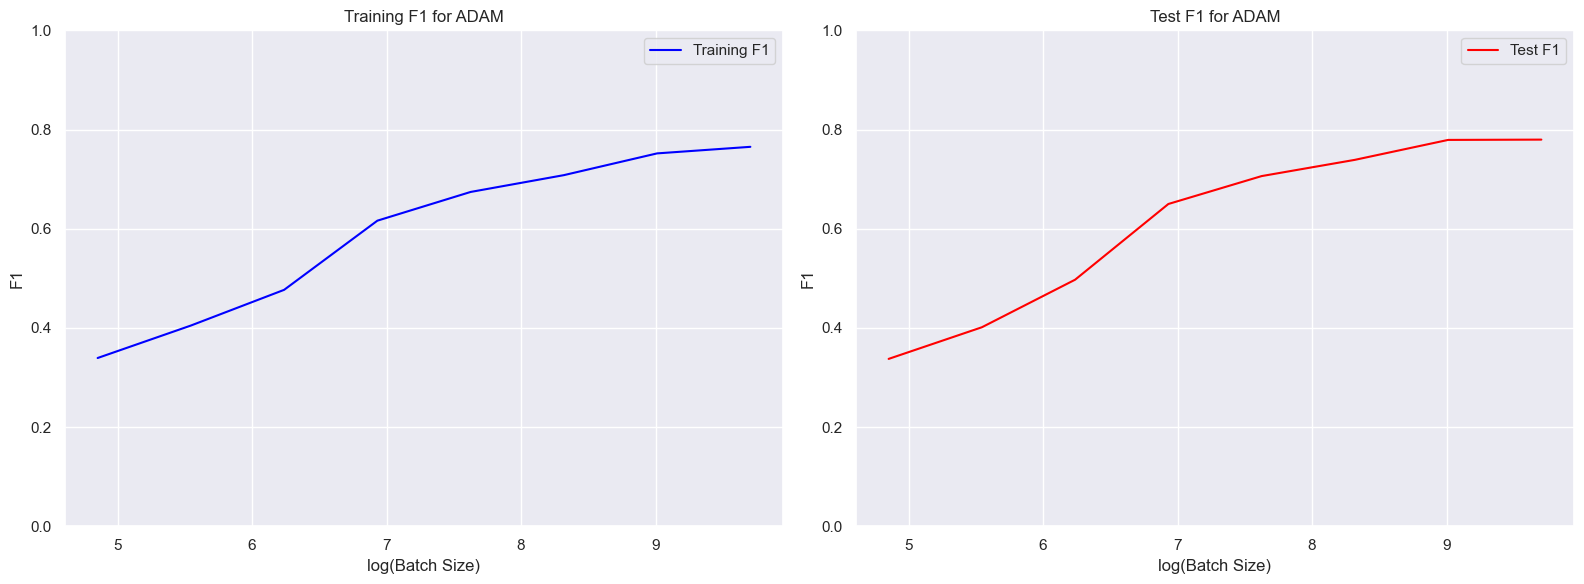

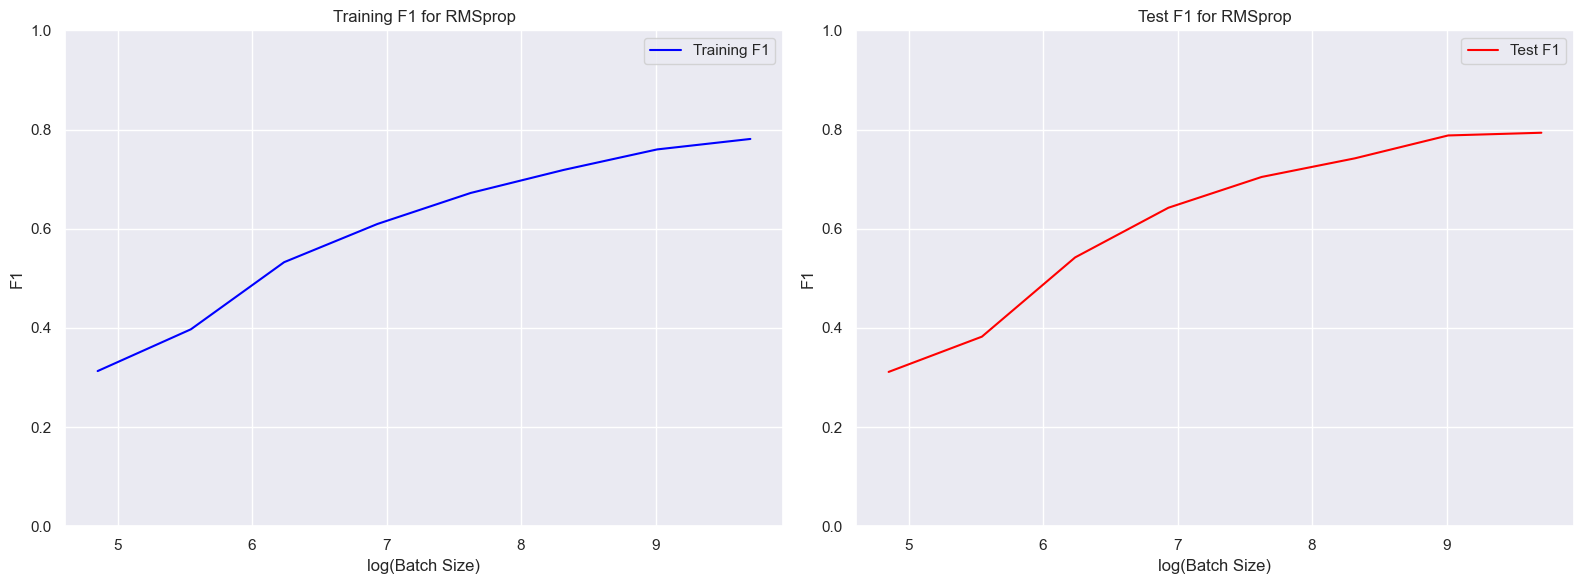

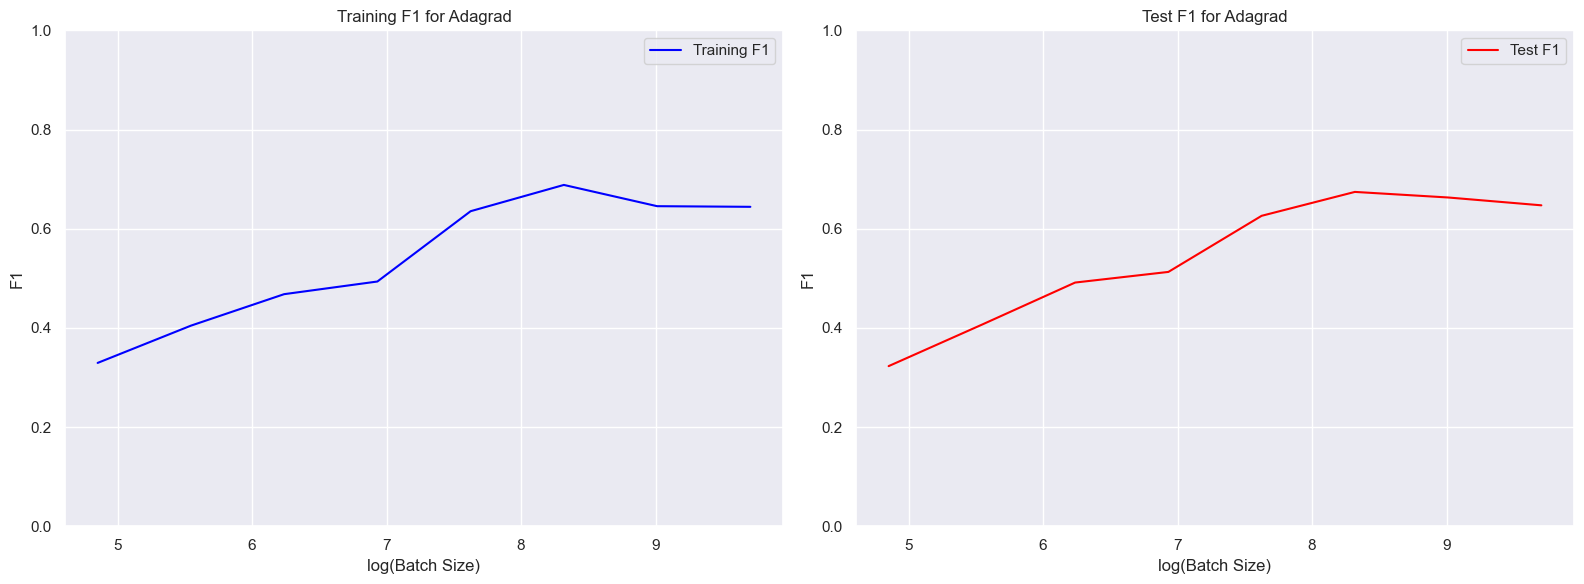

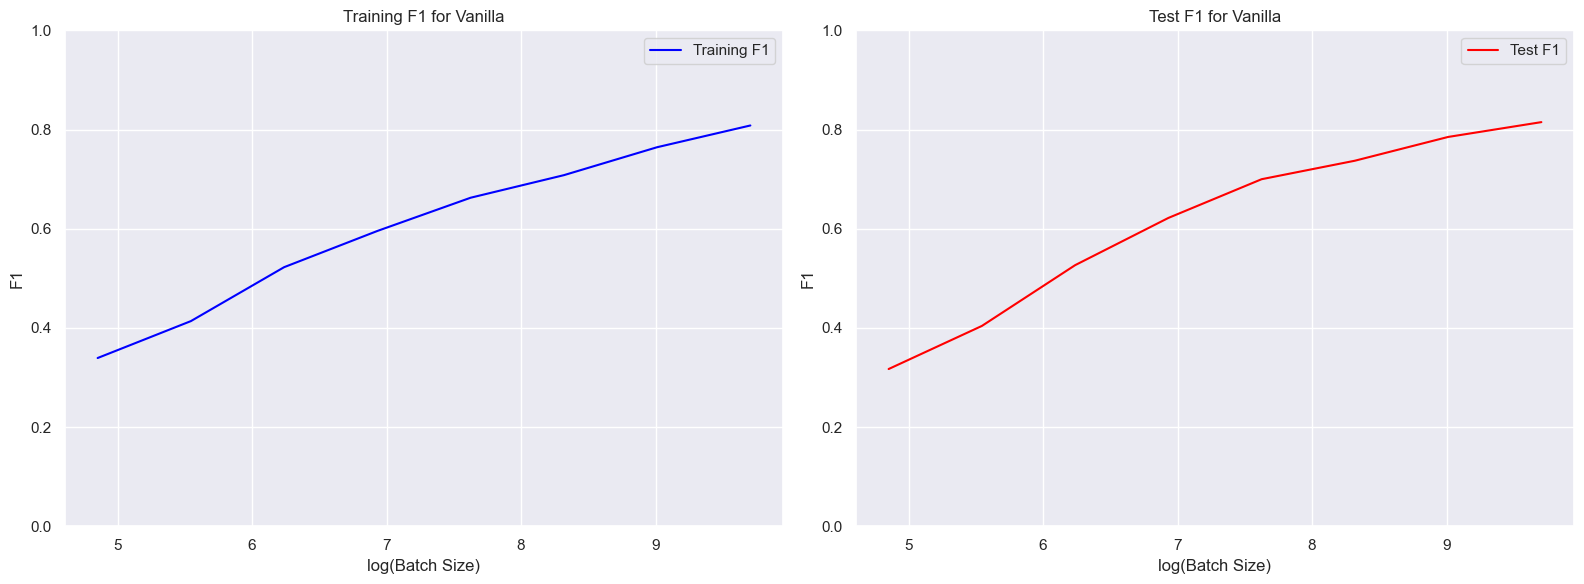

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract methods and batch sizes from the accuracy_histories
methods = list(accuracy_histories_train.keys())
batch_sizes = list(accuracy_histories_train[methods[0]].keys())[1:]

# Assuming accuracy_histories_test has the same structure as accuracy_histories_train but for test data

# Logarithmically scaled batch sizes for x-axis
log_batch_sizes = np.log(batch_sizes)

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Training F1
    f1_train = [accuracy_histories_train[method][batch]['F1_score'] for batch in batch_sizes]
    axes[0].plot(log_batch_sizes, f1_train, color='blue', label='Training F1')
    axes[0].set_title(f"Training F1 for {method}")
    axes[0].set_xlabel("log(Batch Size)")
    axes[0].set_ylabel("F1")
    axes[0].set_ylim(0, 1)  # Assuming F1 is between 0 and 1
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Test F1
    f1_test = [accuracy_histories_test[method][batch]['F1_score'] for batch in batch_sizes]
    axes[1].plot(log_batch_sizes, f1_test, color='red', label='Test F1')
    axes[1].set_title(f"Test F1 for {method}")
    axes[1].set_xlabel("log(Batch Size)")
    axes[1].set_ylabel("F1")
    axes[1].set_ylim(0, 1)  # Assuming F1 is between 0 and 1
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


The graphs show that more the batch is big more the model is accurate. this relation is more linear in Vanilla and RMSprop. 

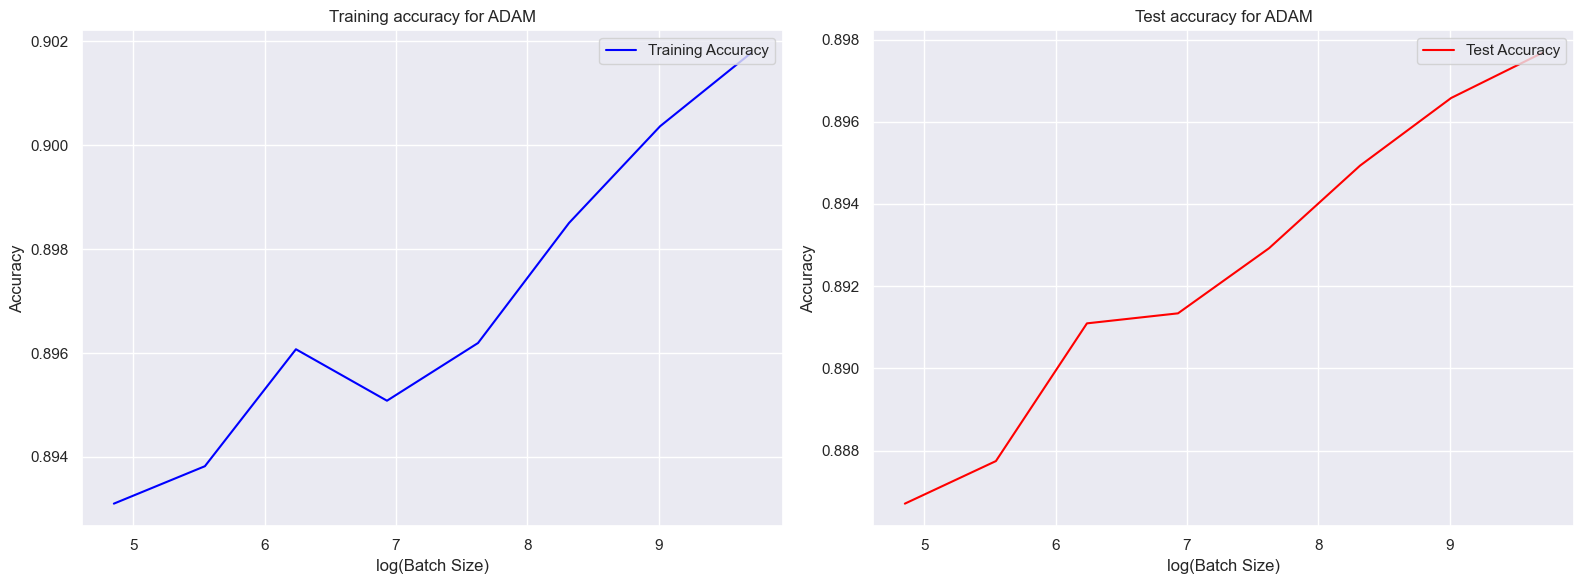

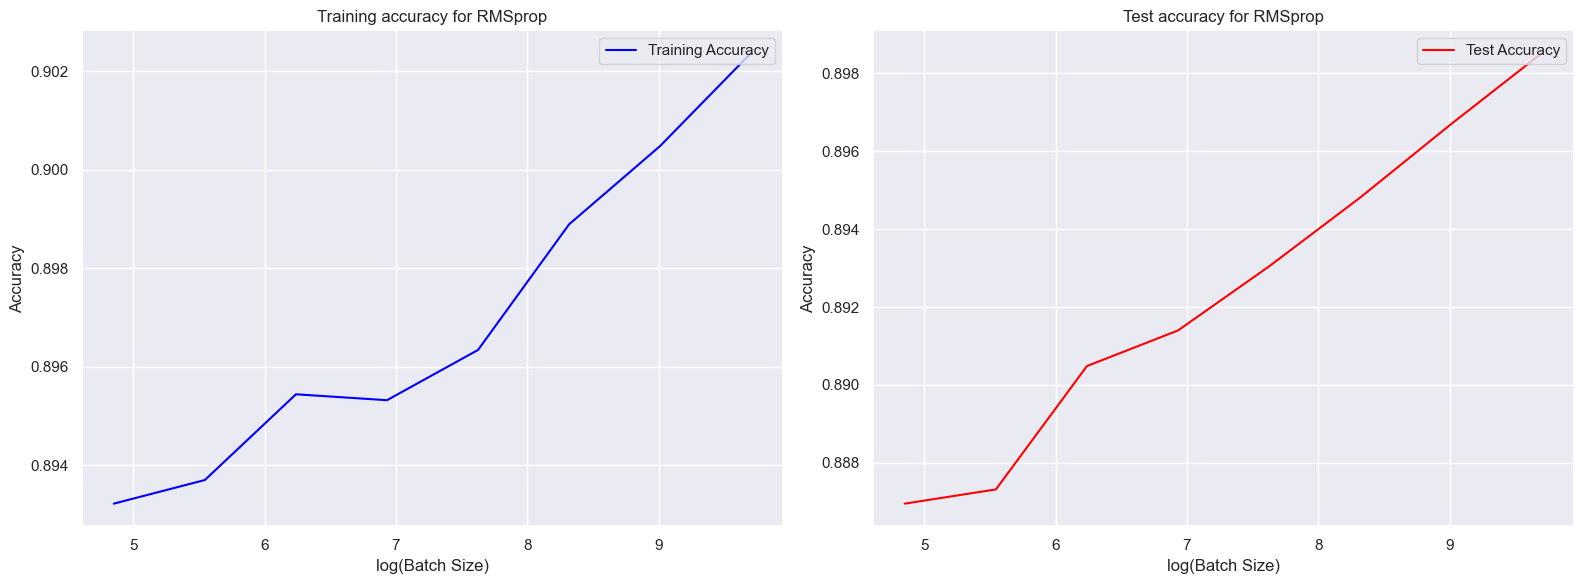

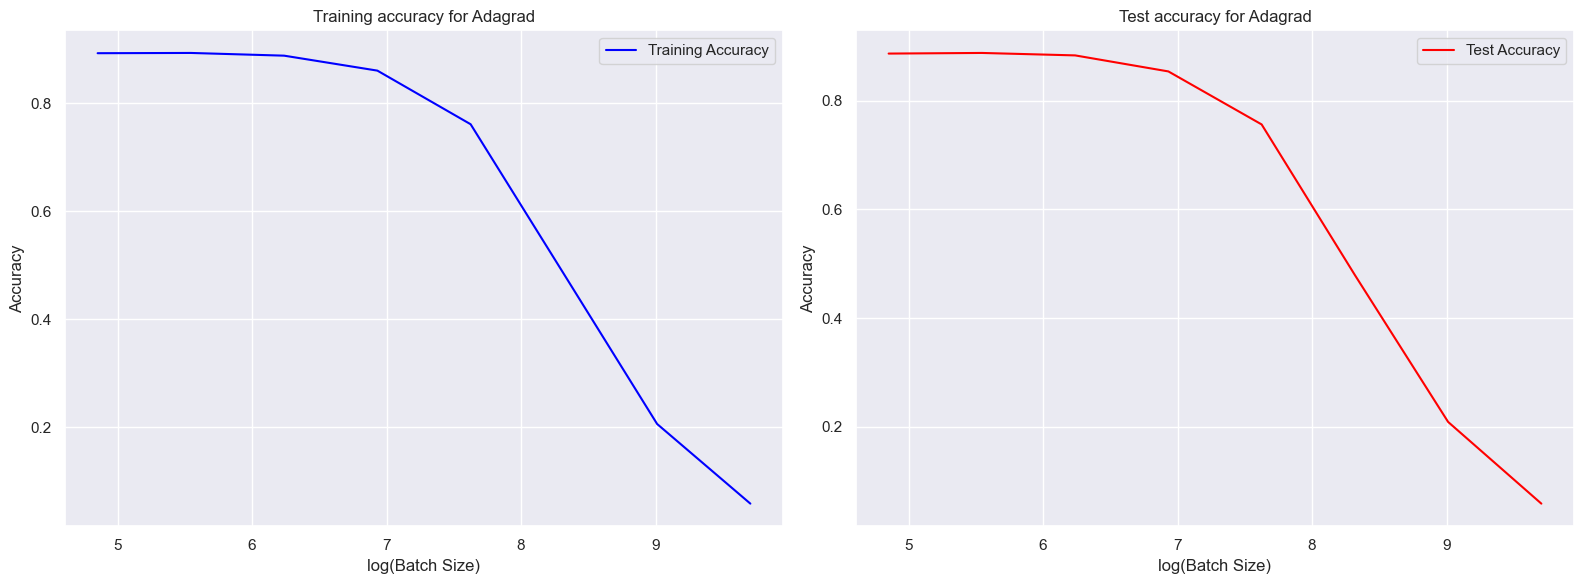

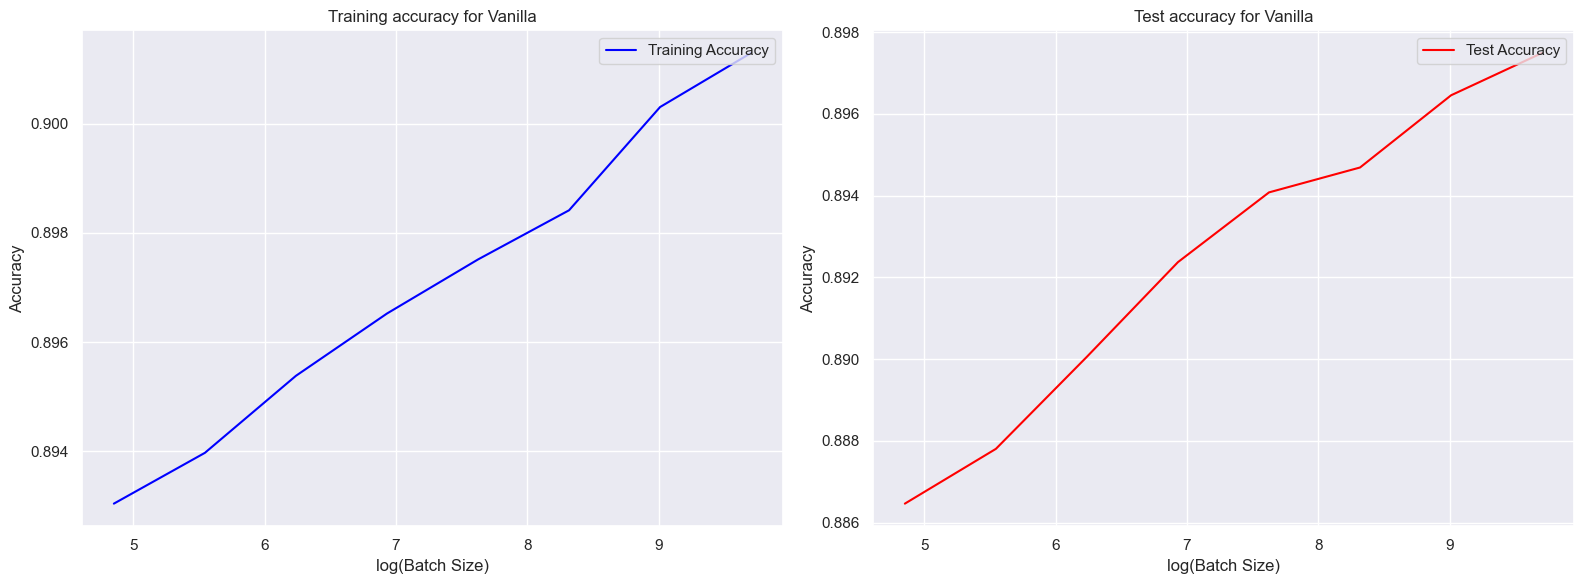

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract methods and batch sizes from the accuracy_histories
methods = list(accuracy_histories_train.keys())
batch_sizes = list(accuracy_histories_train[methods[0]].keys())[1:]

# Assuming accuracy_histories_test has the same structure as accuracy_histories_train but for test data

# Logarithmically scaled batch sizes for x-axis
log_batch_sizes = np.log(batch_sizes)

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Training F1
    acc_train = [accuracy_histories_train[method][batch]['good_pred'] for batch in batch_sizes]
    axes[0].plot(log_batch_sizes, acc_train, color='blue', label='Training Accuracy')
    axes[0].set_title(f"Training accuracy for {method}")
    axes[0].set_xlabel("log(Batch Size)")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Test F1
    acc_test = [accuracy_histories_test[method][batch]['good_pred'] for batch in batch_sizes]
    axes[1].plot(log_batch_sizes, acc_test, color='red', label='Test Accuracy')
    axes[1].set_title(f"Test accuracy for {method}")
    axes[1].set_xlabel("log(Batch Size)")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


the trend is the same that F1 score, more the batch is big more the model is accurate. This is the opposit of the loss. We can call that a "sacrifice" of perfomence in profit of the convergence rapidity 

# Gamma impact

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


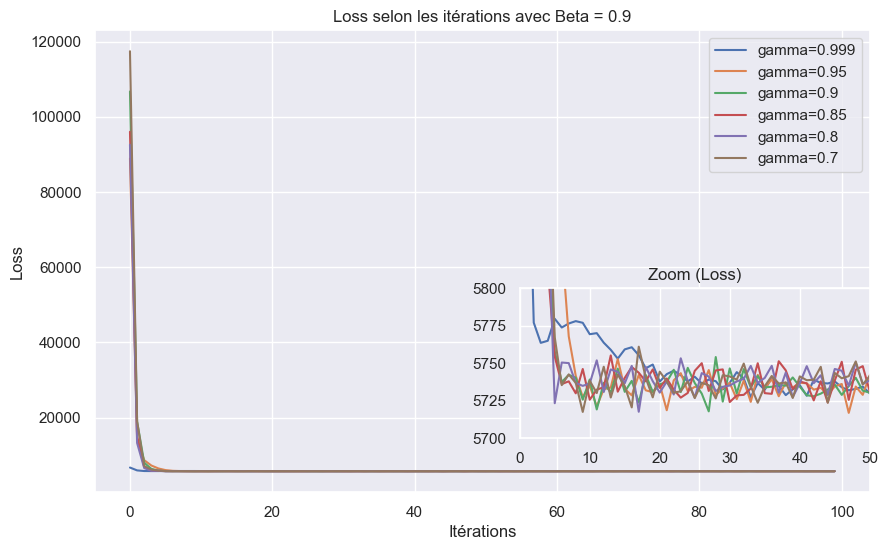

In [20]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Liste des valeurs de "Gamma" à tester
gamma_values = [0.999, 0.95, 0.9, 0.85, 0.8, 0.7]

# Paramètres communs pour tous les modèles
beta = 0.9
nb_epochs = 100
batch_size = 1024

# séparation en un train et test set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des loss
loss_history = {}

# Graphe des Loss
plt.figure(figsize=(10, 6))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)
ax_zoom = plt.axes([0.55, 0.2, 0.35, 0.25]) 

# stockage des modèles pour les analyses F1
modeles = []

# on parcours les différentes valeurs de gamma
for gamma in gamma_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)

    # ajout à la liste des modèles
    modeles.append(model)

    # ajout de la courbe de zoom
    ax_zoom.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")
    # ajout sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")

# TGraphique Principal
ax_main.set_title("Loss selon les itérations avec Beta = 0.9")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()

# Grahique Zoom
ax_zoom.set_title("Zoom (Loss)")
ax_zoom.set_xlim(0, 50) 
ax_zoom.set_ylim(5700, 5800)  


plt.show()


All the gamma values oscillate to a greater or lesser extent, and converge at different speeds. On closer inspection, although the gamma value 0.999 oscillates for a small number of iterations, it tends to stabilise and converge more quickly than the other values.

100%|██████████| 100/100 [00:01<00:00, 62.74it/s]


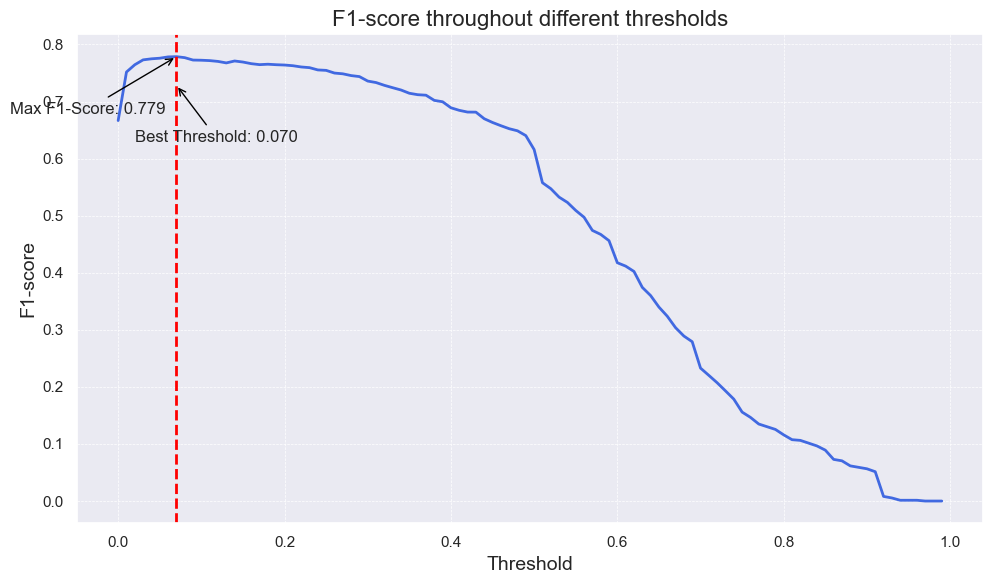

100%|██████████| 100/100 [00:01<00:00, 69.93it/s]


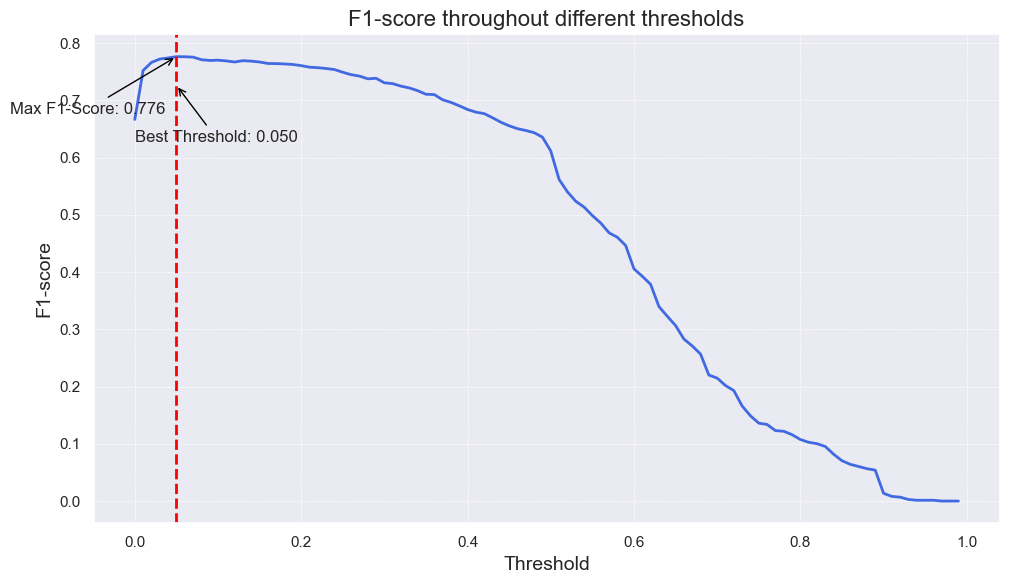

100%|██████████| 100/100 [00:01<00:00, 70.93it/s]


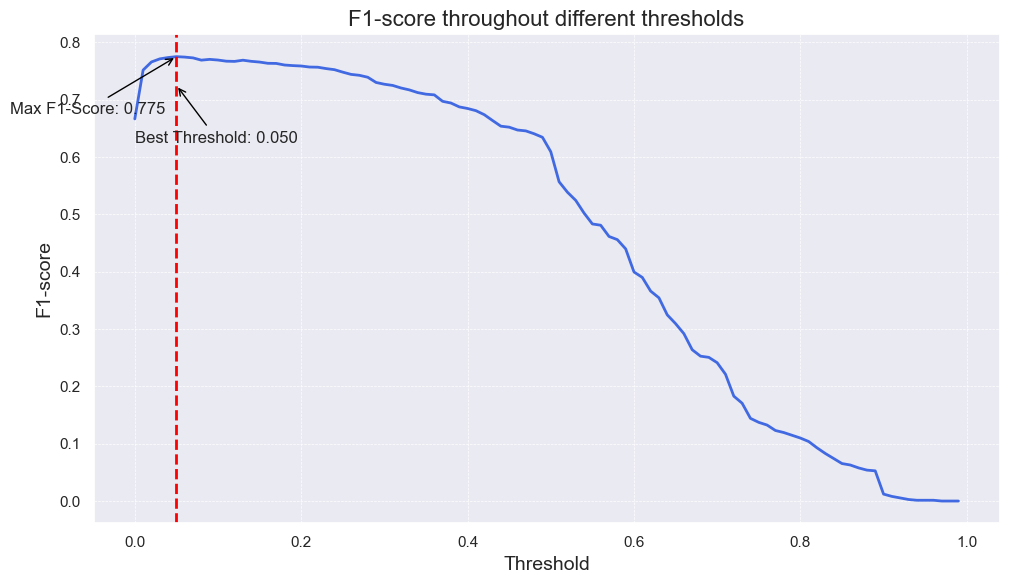

100%|██████████| 100/100 [00:01<00:00, 77.50it/s]


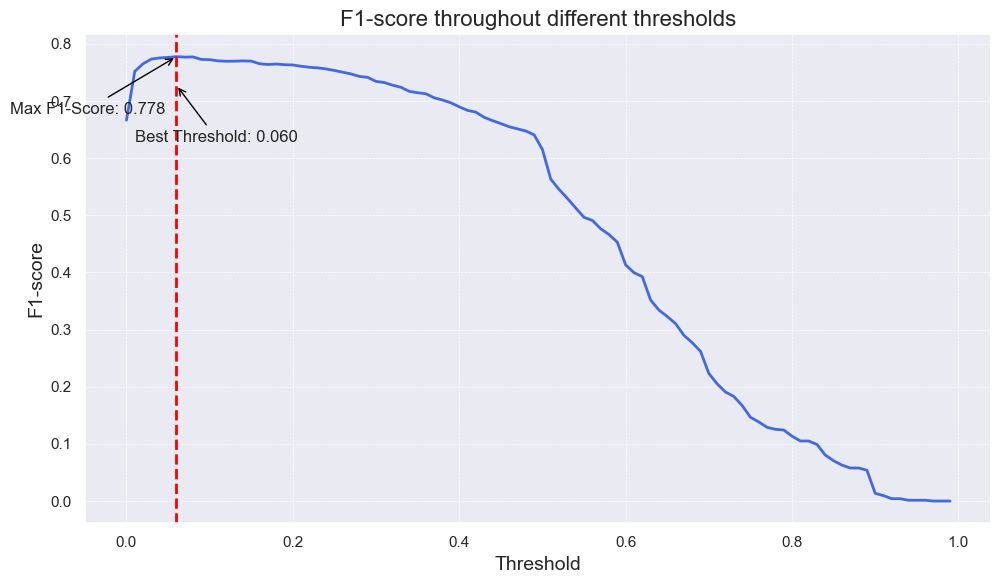

100%|██████████| 100/100 [00:01<00:00, 64.02it/s]


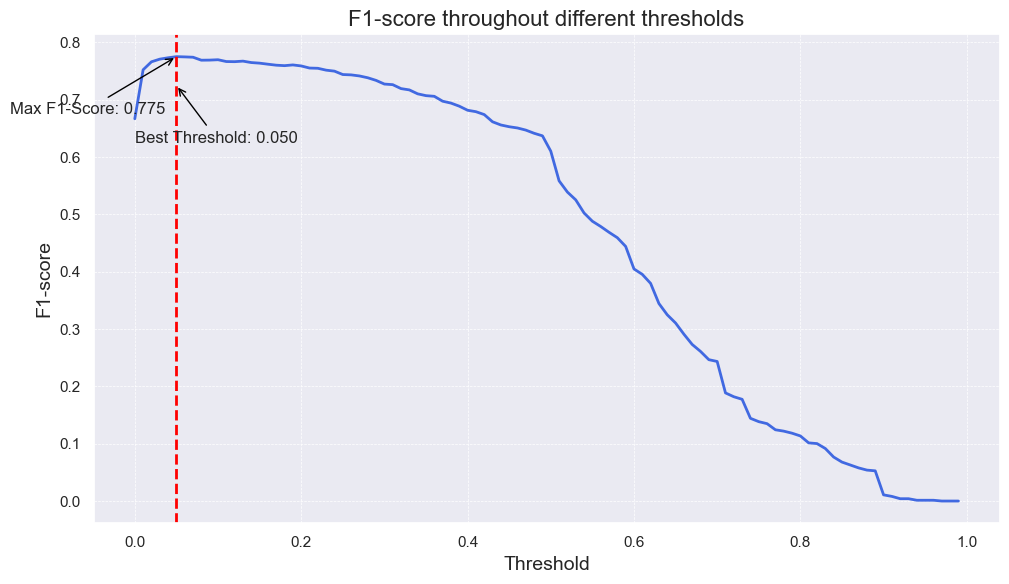

100%|██████████| 100/100 [00:01<00:00, 55.93it/s]


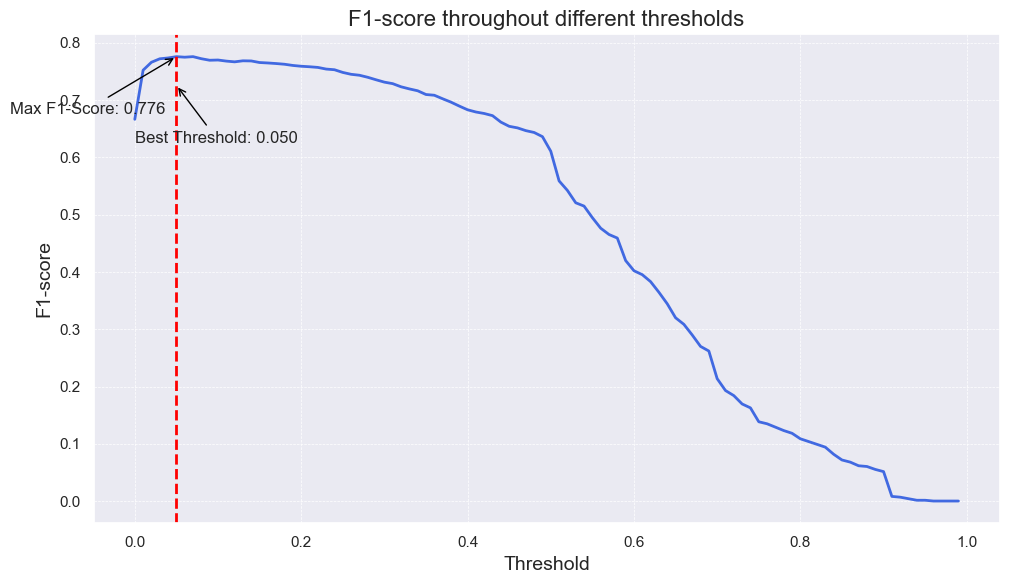

In [21]:
# on trace pour chaque valeur de gamma le graphe du F1 score selon les différents thresholds
score = []
for model in modeles:
    model.find_thresh(X,y)
    score.append(model.accuracy_evaluation(X,y,thresh=model.thresh_, vizualisation=False))

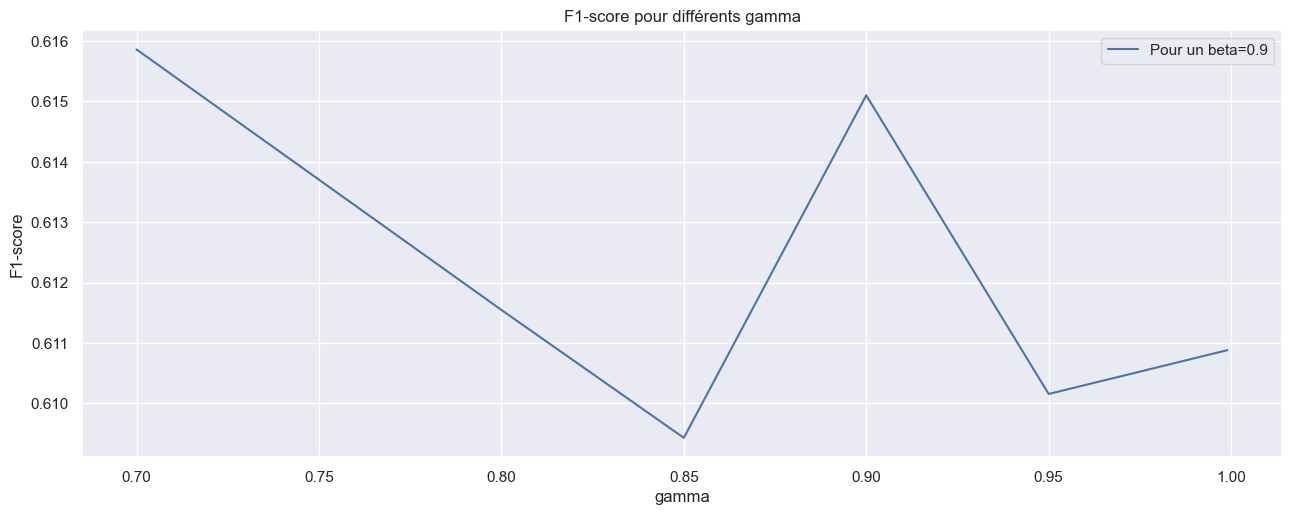

In [22]:
# on représente maintenant tous les F1 score selon les gamma
f1_score = [Fscore['F1_score'] for Fscore in score]
gamma = [0.7, 0.8, 0.85,0.9,0.95,0.999, ]
plt.plot(gamma, f1_score,label="Pour un beta=0.9")
plt.title('F1-score pour différents gamma')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('F1-score')
plt.subplots_adjust(right=2,top=1)
plt.show()

No matter the gamma value we choose, the maximum F1-score and the associated Threshold are not very differents. We will keep the basic gamma value at 0.999 as recommanded

# Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


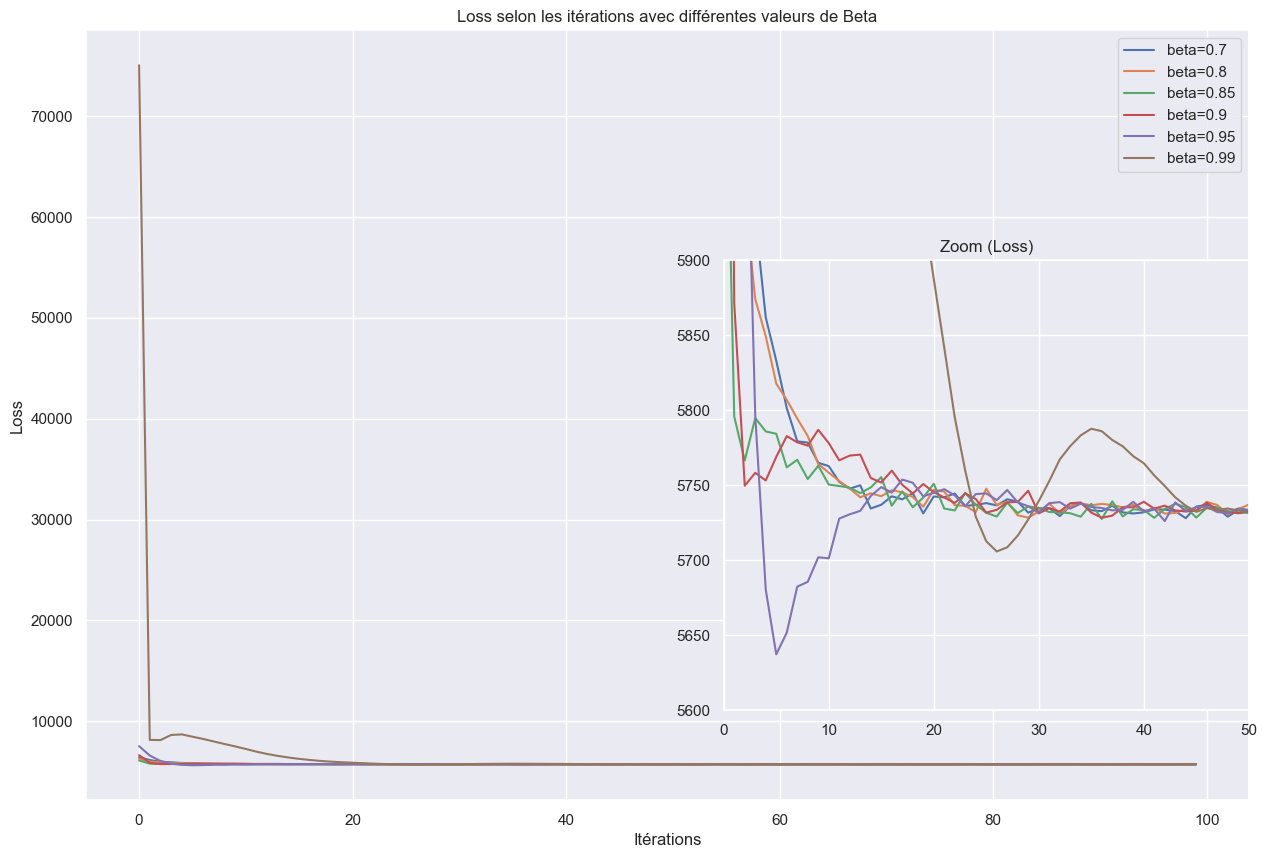

In [23]:
#TODO : Study Loss and F1-score

# Liste des valeurs de "Beta" à tester
beta_values = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
gamma = 0.999

# Paramètres pour tous les modèles
nb_epochs = 100
batch_size = 1024

# test & train set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des Loss
loss_history = {}

# Plot en sortie
plt.figure(figsize=(15, 10))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)
ax_zoom = plt.axes([0.55, 0.2, 0.35, 0.45]) 

# Liste pour stocker les modèles
modeles = []

for beta in beta_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)

    # Tracez la courbe de zoom
    ax_zoom.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")

    # Tracez la courbe sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"beta={beta}")

    # ajout a la liste des modèles
    modeles.append(model)

# Titre et légende du graphique principal
ax_main.set_title("Loss selon les itérations avec différentes valeurs de Beta")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()

# Titre et légende du graphique de zoom
ax_zoom.set_title("Zoom (Loss)")
ax_zoom.set_xlim(0, 50)  # Limite de l'axe x du zoom
ax_zoom.set_ylim(5600, 5900)  # Limite de l'axe y du zoom


plt.show()


For the beta values 0.999 and 0.95 we can see a alrge variation and their cuvre converging slower than for others beta values. the red one associated to beta = 0.9 seems to be a good compromise between a fast convergence and a small variance

100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


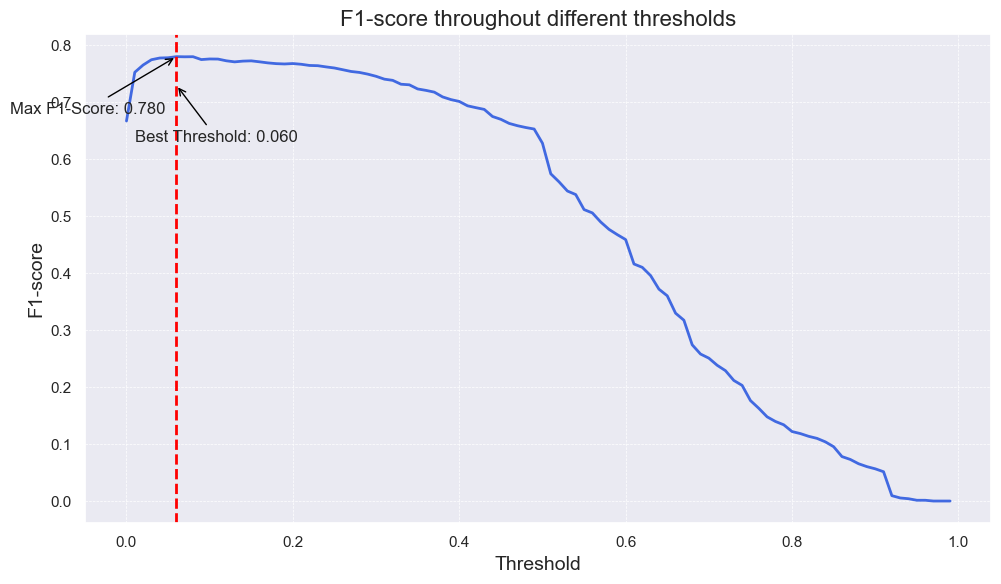

100%|██████████| 100/100 [00:01<00:00, 81.91it/s]


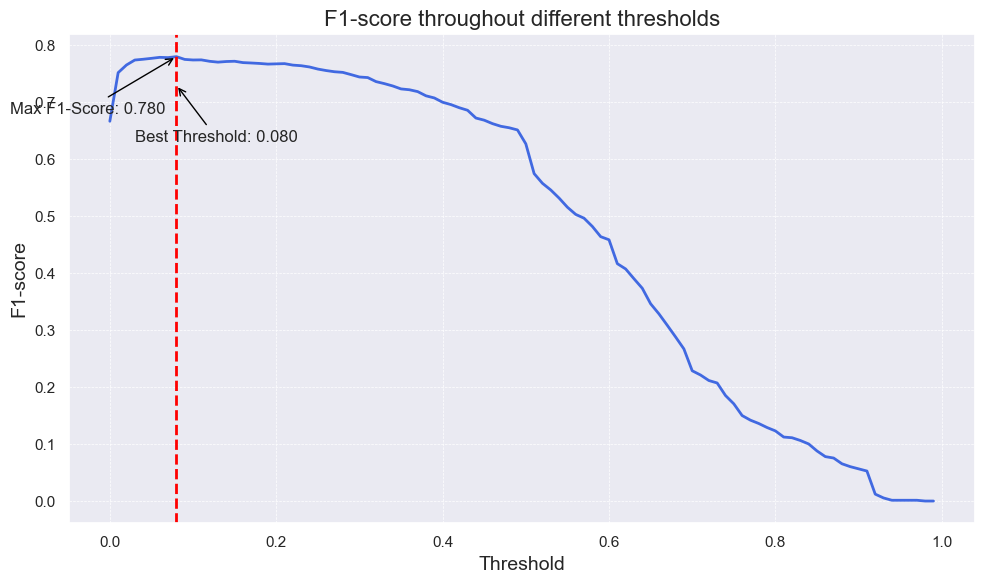

100%|██████████| 100/100 [00:01<00:00, 75.38it/s]


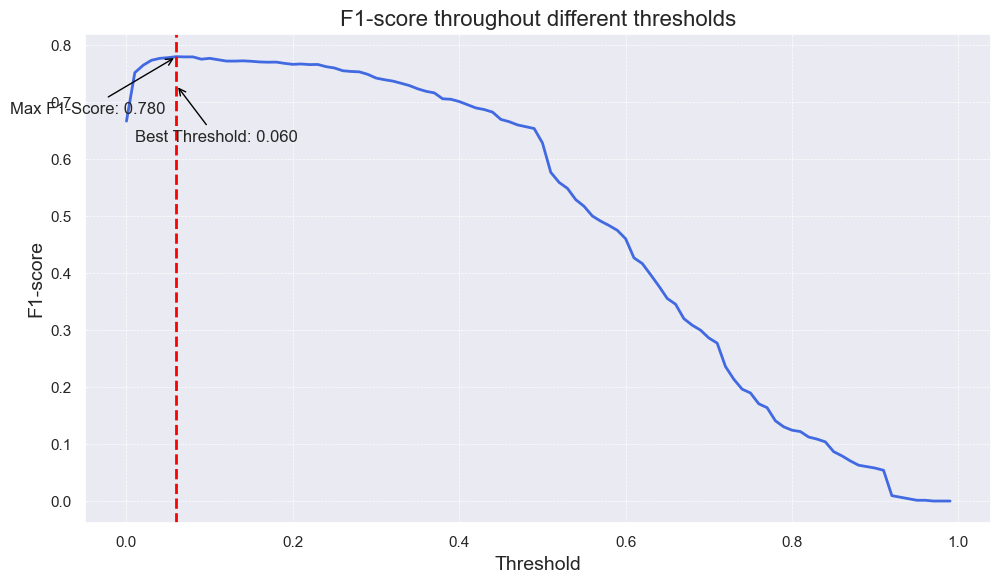

100%|██████████| 100/100 [00:01<00:00, 67.36it/s]


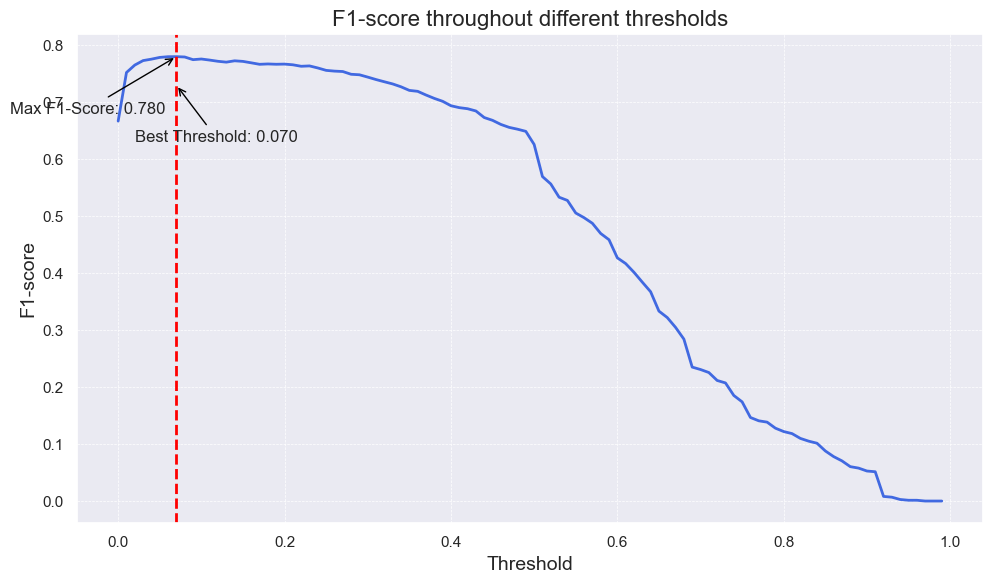

100%|██████████| 100/100 [00:01<00:00, 68.57it/s]


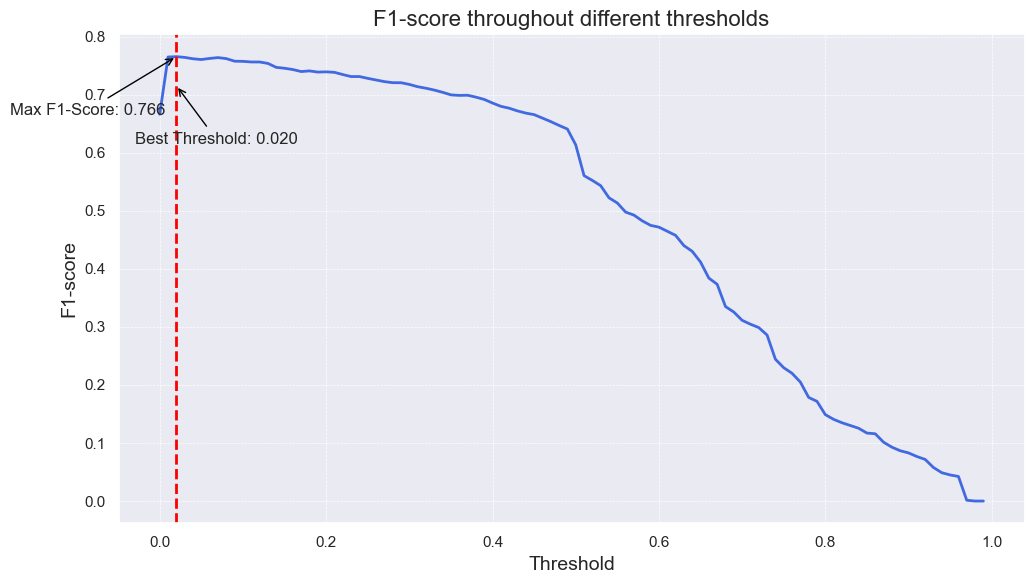

100%|██████████| 100/100 [00:01<00:00, 78.51it/s]


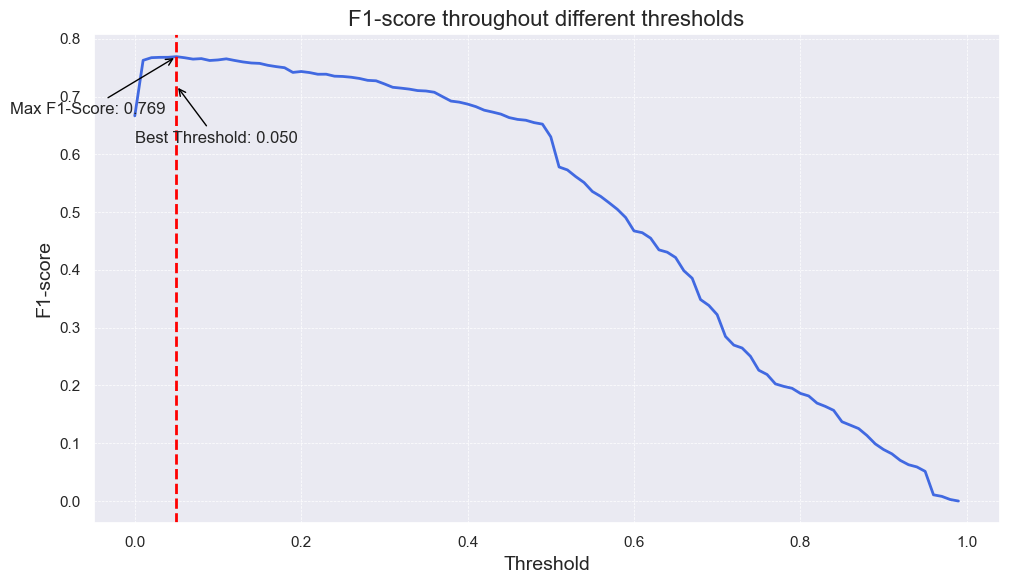

In [24]:
# on trace les différens grpahe de F1 score en fonction des threshold
scores = []
for model in modeles:
    model.find_thresh(X,y)
    scores.append(model.accuracy_evaluation(X,y,thresh=model.thresh_, vizualisation=False))

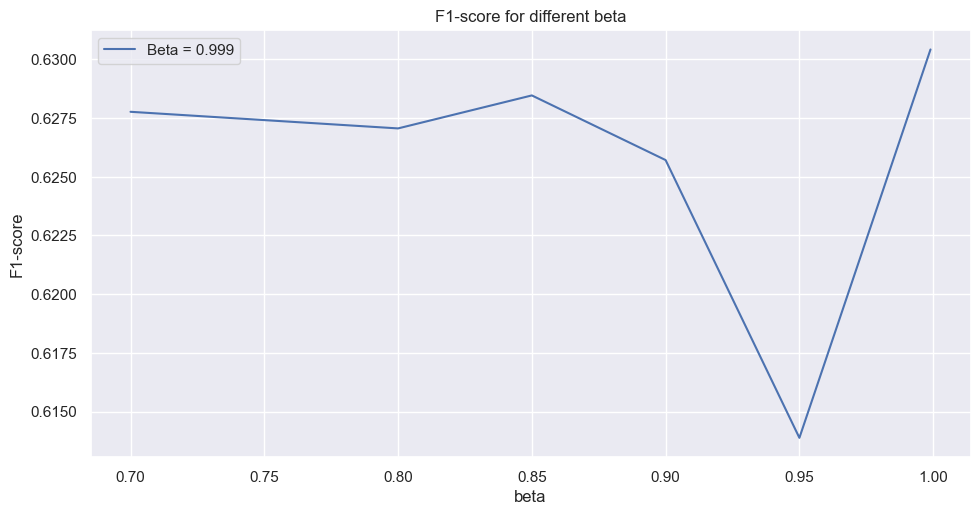

In [25]:
f1_scores = [score['F1_score'] for score in scores]
beta = [0.7, 0.8, 0.85, 0.9,0.95,0.999]
plt.plot(beta, f1_scores,label="Beta = 0.999")
plt.title('F1-score for different beta')
plt.legend()
plt.xlabel('beta')
plt.ylabel('F1-score')
plt.subplots_adjust(right=1.5,top=1)
plt.show()

For this differents Beta values, the F1 score stays around 0.62. We should take a prudent Beta value like 0.9? To conclude it could be interesting to study again the impact of differnet bacth size for these value

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


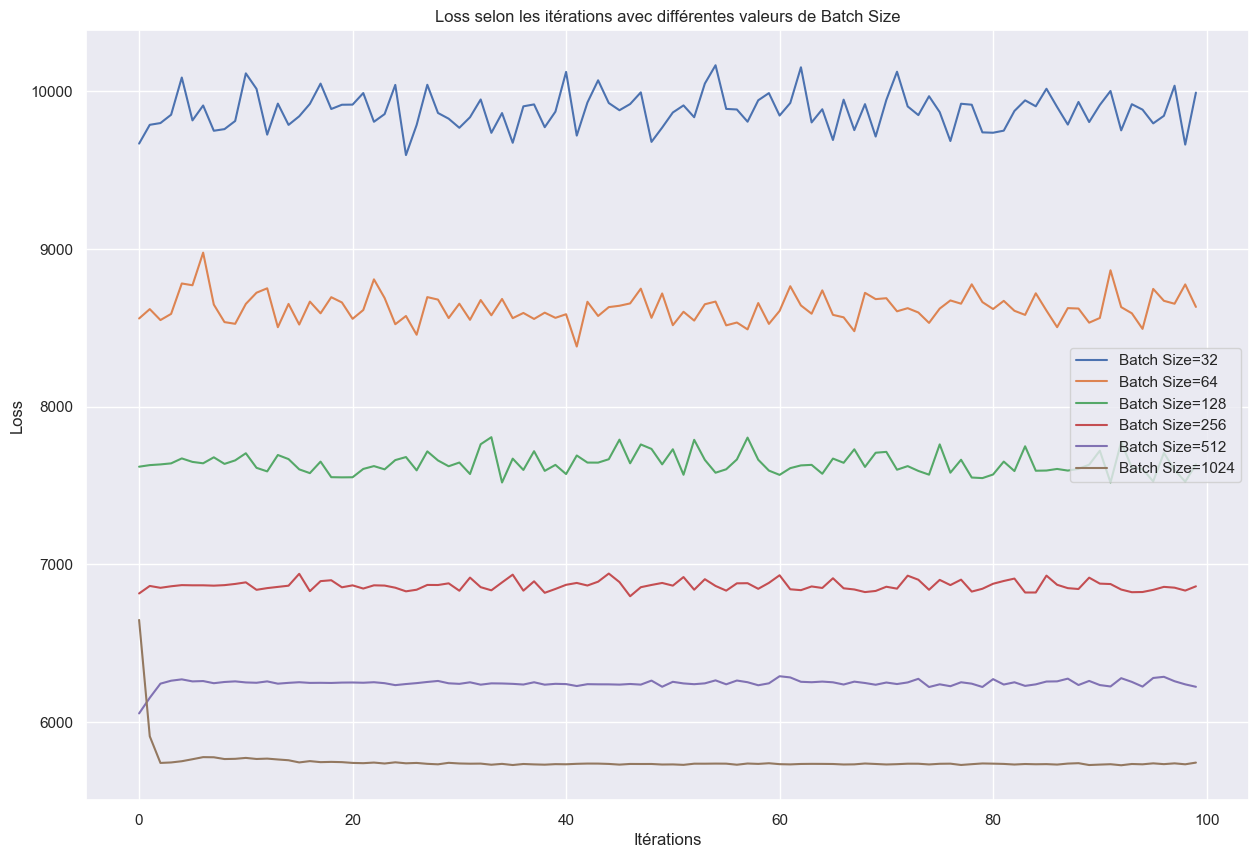

In [26]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Liste des valeurs de "Batch Size" à tester
batch_size_values = [32, 64, 128, 256, 512, 1024]
gamma = 0.999
beta = 0.9

# Paramètres pour tous les modèles
nb_epochs = 100

# test & train set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des Loss
loss_history = {}

# Plot en sortie
plt.figure(figsize=(15, 10))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)

# Liste pour stocker les modèles
modeles = []

for batch_size in batch_size_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)


    # Tracez la courbe sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"Batch Size={batch_size}")

    # ajout à la liste des modèles
    modeles.append(model)

# Titre et légende du graphique principal
ax_main.set_title("Loss selon les itérations avec différentes valeurs de Batch Size")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()



plt.show()


The biggest difference is made with the jump from 128 to 256 batch size